## Import libraries

In [1]:
import numpy as np
import re
import math
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import numpy as np
from dataset.utils import load_and_process_data, generate_orth, load_data,extract_features
from dataset.dataset import SyntheticDataset, SimuDataset
from model.linear import ModifiedLinear
from model.shallow import ModifiedShallow
from model.bilinear import ModifiedBiLinear
from strategies.al_sampling import MTALSampling
from strategies.baseline_sampling_simu import RandomSampling, FixBaseSampling
from trainer.pytorch_passive_trainer import PyTorchPassiveTrainer
from trainer.trainer import *
import matplotlib.pyplot as plt
from metrics.utils_simu import rowspace_dist, rowspace_dist2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

$x \in\mathbb{R}^n$ represents shared features across all tasks. $w \in\mathbb{R}^m$ represents non-shared(environment) variables for each tasks.

We are insterested in system where $f(x,w) = \phi(x) * \phi(w)$. There exists a target task $\phi_x(x_{target}) * \phi_w(w_{target})$. However, there are some limitations to directly access target dataset. We want to sample from some sources tasks that could help us to better learn the representation functions $\phi_x$ and $\phi_w$ for target tasks.

## Load and Process Data

In our case, $\phi_w$ is a linear transformation represented by a matrix $B_w$. There are n source tasks with non-shared environment variable $\{w_1,...,w_n\}$. We generate data according to 

$$y=\phi(x) * B_w * w_i$$

for every task i, where $\phi(x)$ is a MLP model.

Here, with dataset Neural-fly. $x \in\mathbb{R}^{11}$ includes features verlocity(v), attitude(q), motor speed command(pwm). 

Then $\phi(x) \in\mathbb{R}^{11 \times 33} $

There are 33 possible source tasks($w_i \in\mathbb{R}^{33}$ is a one hot vector) with different wind speed $\in\mathbb{R}$ and $fa$ vector $\in\mathbb{R}^3$ , $B_w \in\mathbb{R}^{2 \times 33}$.

The output $y$ is a scalar: $\{ fa_i | i \in [x,y,z] \}$

In [2]:
shared_features = ['v', 'q', 'pwm']
rawdata_nontrans = load_data("./data/training/")
rawdata_transfer = load_data("./data/training-transfer/")


In [5]:
raw_data = rawdata_nontrans + [0] + rawdata_transfer

In [6]:
input_dim = 11 # dim(x)
embed_dim = 2 # dim(\phi(x))
task_dim = 33 # dim(w)
source_task_dict = {}
test_task_dict = {}

In [7]:
input_data = {}
input_label = {}
input_ws = {}
task_embed_matrix = []
fa_list = ["x","y","z"]
transfer = "drone_type_A"
w_matrix = np.identity(33)
count = -1
for task_data in raw_data:
   if task_data == 0:
      transfer = "drone_type_B"
      continue
   if task_data["condition"] == "nowind":
      wind_speed = 0
   else:
      wind_speed = re.search(r'\d+', task_data["condition"]).group()
   for dim in range(task_data["fa"].shape[1]):
      # input_data.append(np.array(extract_features(task_data,shared_features)))
      # input_label.append(task_data["fa"][:,dim])
      count += 1
      task_name = f"{transfer}_{wind_speed}_{fa_list[dim]}"
      input_data[task_name] = np.array(extract_features(task_data,shared_features))
      input_label[task_name] = task_data["fa"][:,dim]
      # input_ws[task_name] = np.array([w_matrix[count]] * task_data["fa"].shape[0])
      input_ws[task_name] = np.array([w_matrix[count]])
      source_task_dict[task_name] = (w_matrix[count],50)
# task_embed_matrix = np.array(task_embed_matrix).T

In [8]:
test_task_dict[list(input_ws.keys())[task_dim-1] + "_test"] = (w_matrix[task_dim-1],50)

In [9]:
task_dict = source_task_dict.copy()
task_dict.update(test_task_dict)

In [10]:
dataset = SimuDataset(input_data, input_label, input_ws)

In [11]:
dataset.get_dataset(source_task_dict, mixed=True)

## Data Overview

In [67]:
length = []
for task in input_label.keys():
  length.append(input_label[task].shape[0])
df = pd.DataFrame({"length":length,"name": list(input_label.keys())})
df = df.sort_values(by="length")

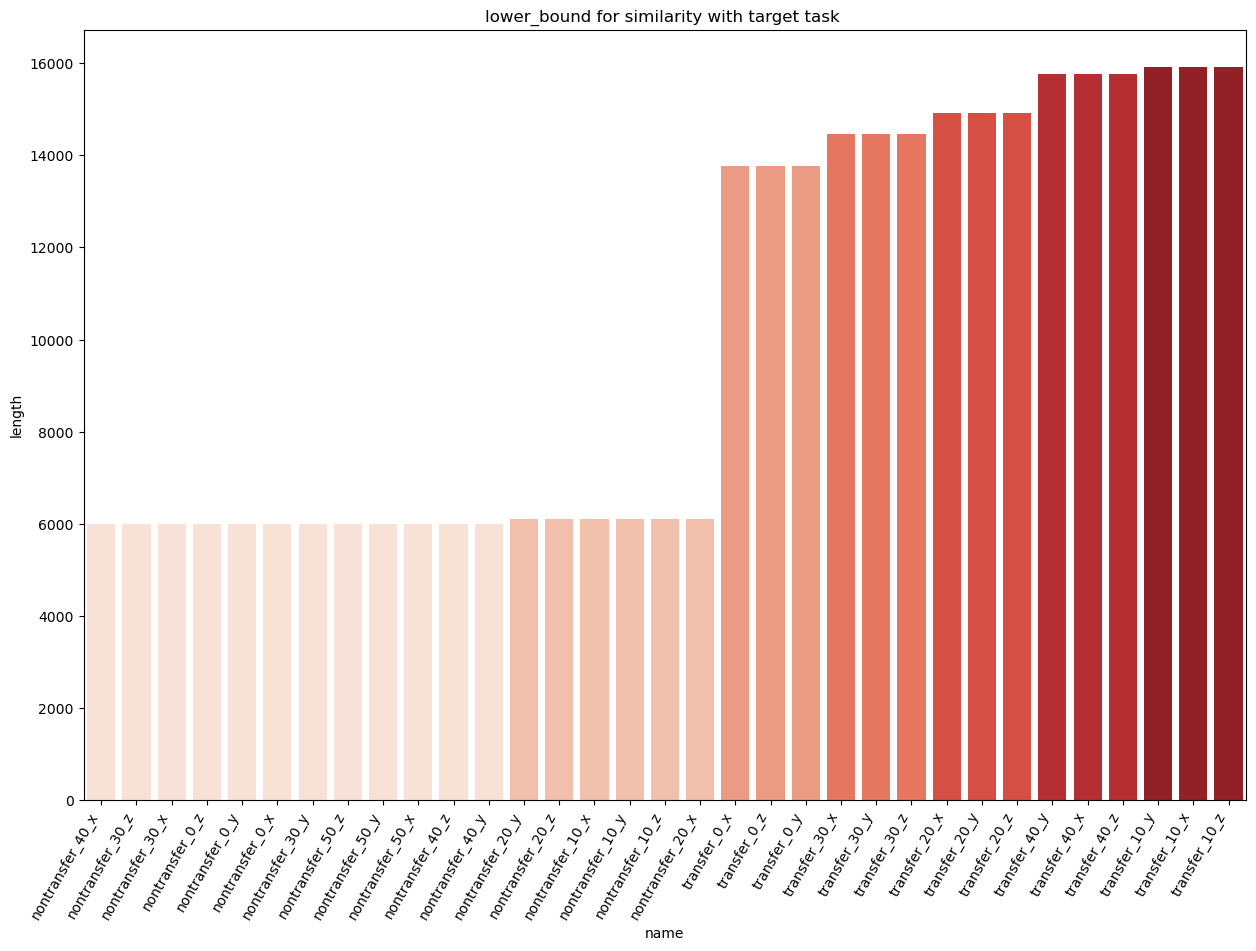

In [68]:
ax = sns.barplot(x = "name", y ="length", data=df, hue = "length",palette='Reds',dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.get_legend().remove()
plt.title(f"lower_bound for similarity with target task ")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [22]:
wind_speed = {}

fa_x = []
fa_y = []
fa_z = []
for data in raw_data:
  if data == 0:
    continue
  fa_x.append(data["fa"][:,0])
  fa_y.append(data["fa"][:,1])
  fa_z.append(data["fa"][:,2])
  

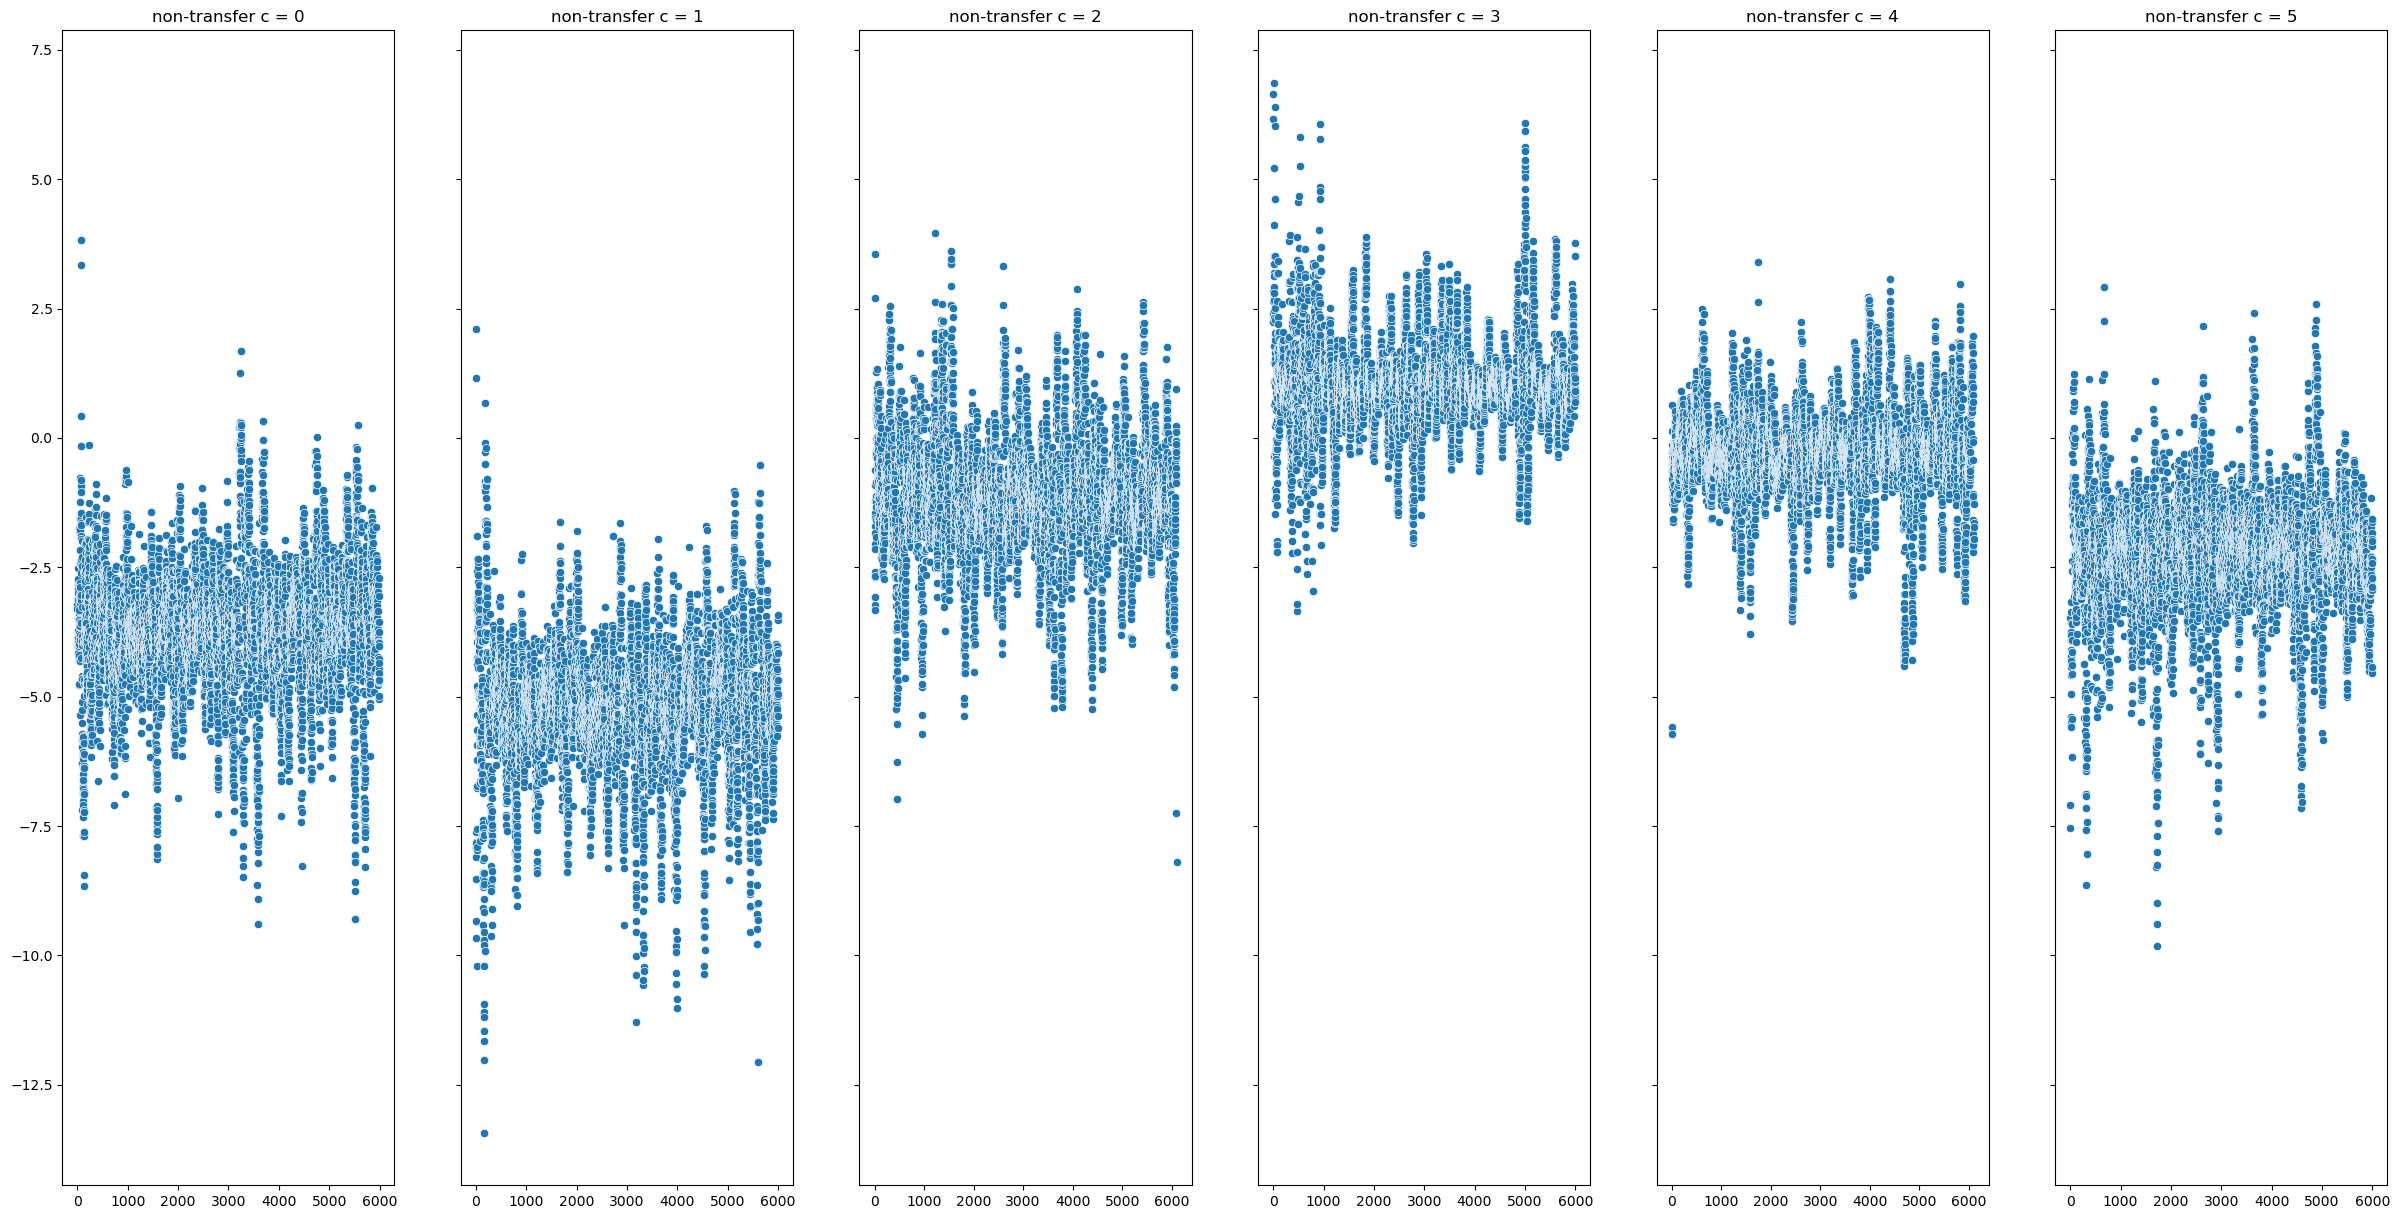

In [41]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig, axes = plt.subplots(1,6, figsize=(30,15),sharey=True)
for i in range(6):
  axes[i].set_title(f"non-transfer c = {i} fa x")
  sns.scatterplot(fa_x[i], ax = axes[i])

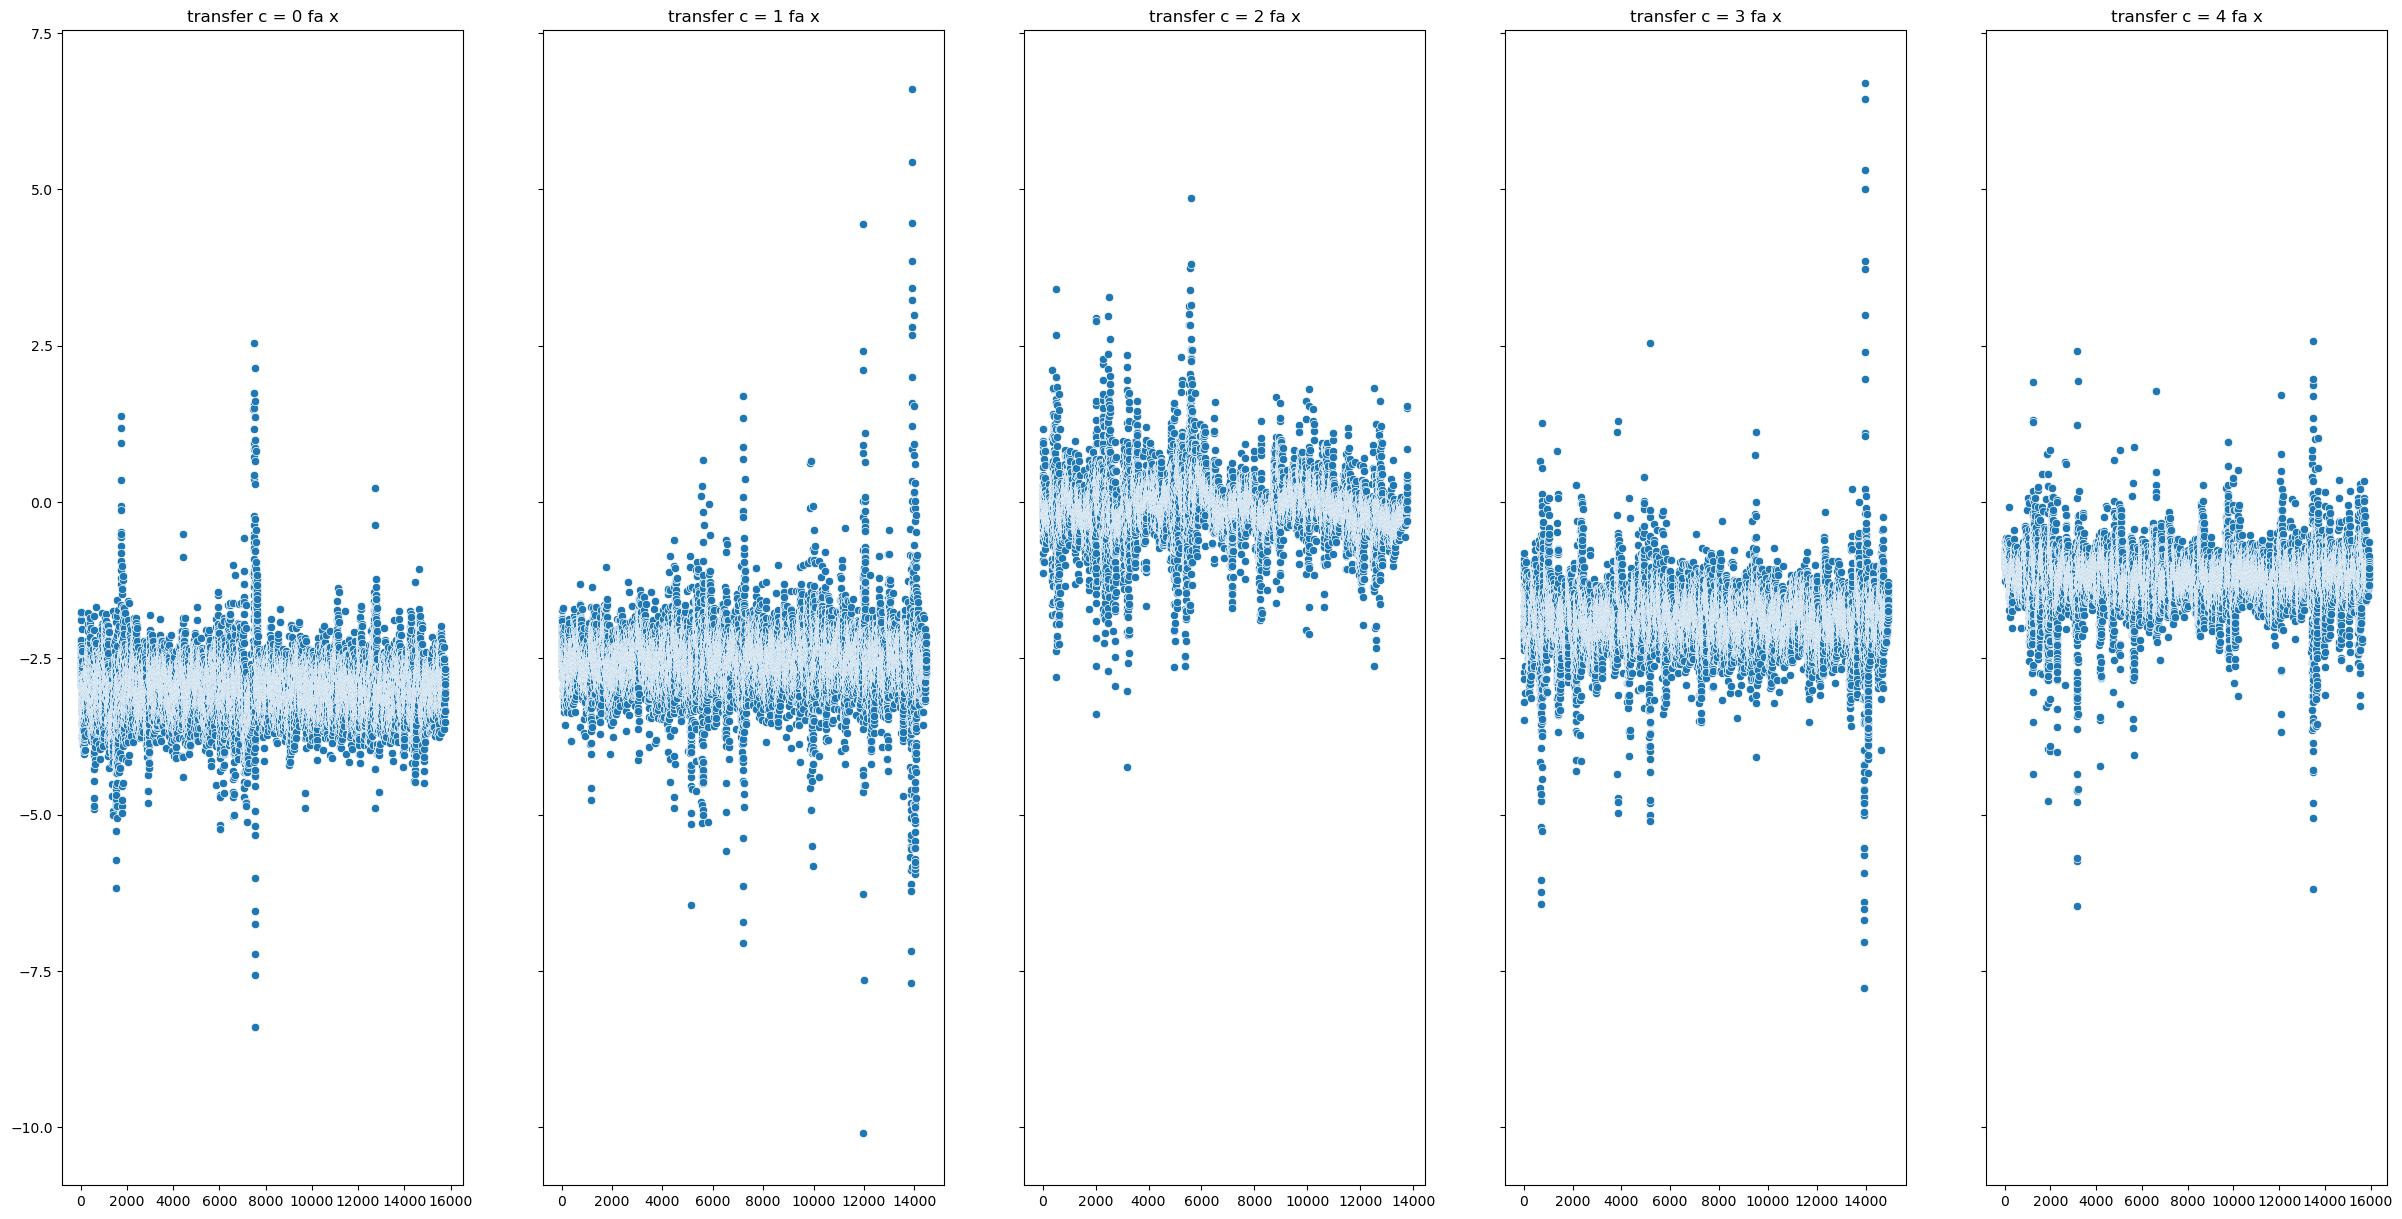

In [44]:
fig, axes = plt.subplots(1,5, figsize=(30,15), sharey=True)
for i in range(5):
  axes[i].set_title(f"transfer c = {i} fa x")
  sns.scatterplot(fa_x[6+i], ax = axes[i])

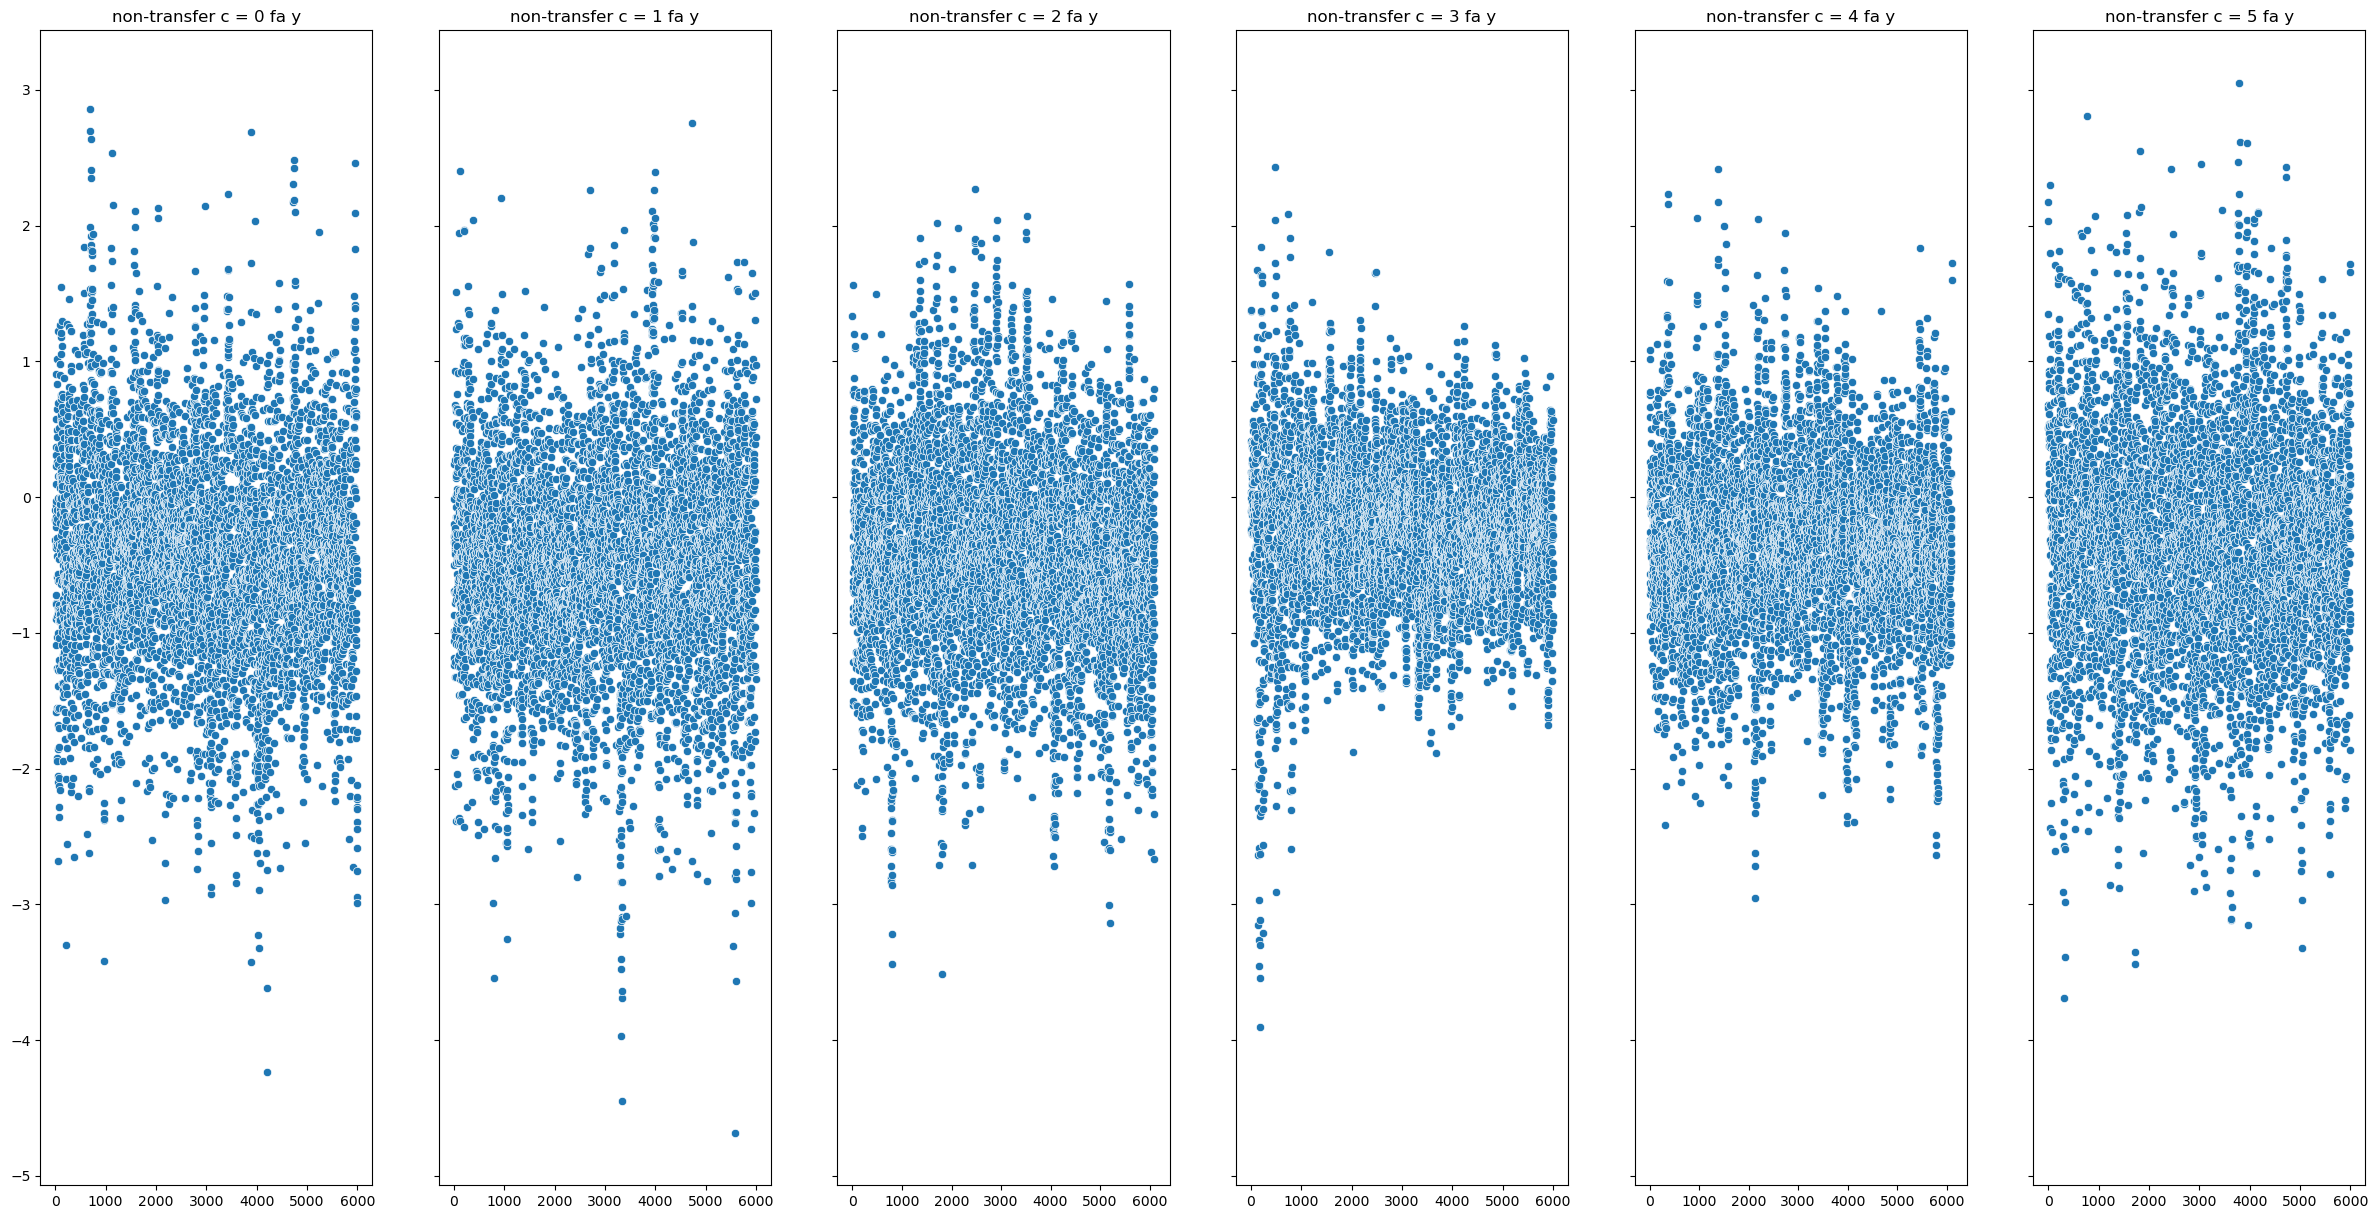

In [46]:
fig, axes = plt.subplots(1,6, figsize=(30,15),sharey=True)
for i in range(6):
  axes[i].set_title(f"non-transfer c = {i} fa y")
  sns.scatterplot(fa_y[i], ax = axes[i])

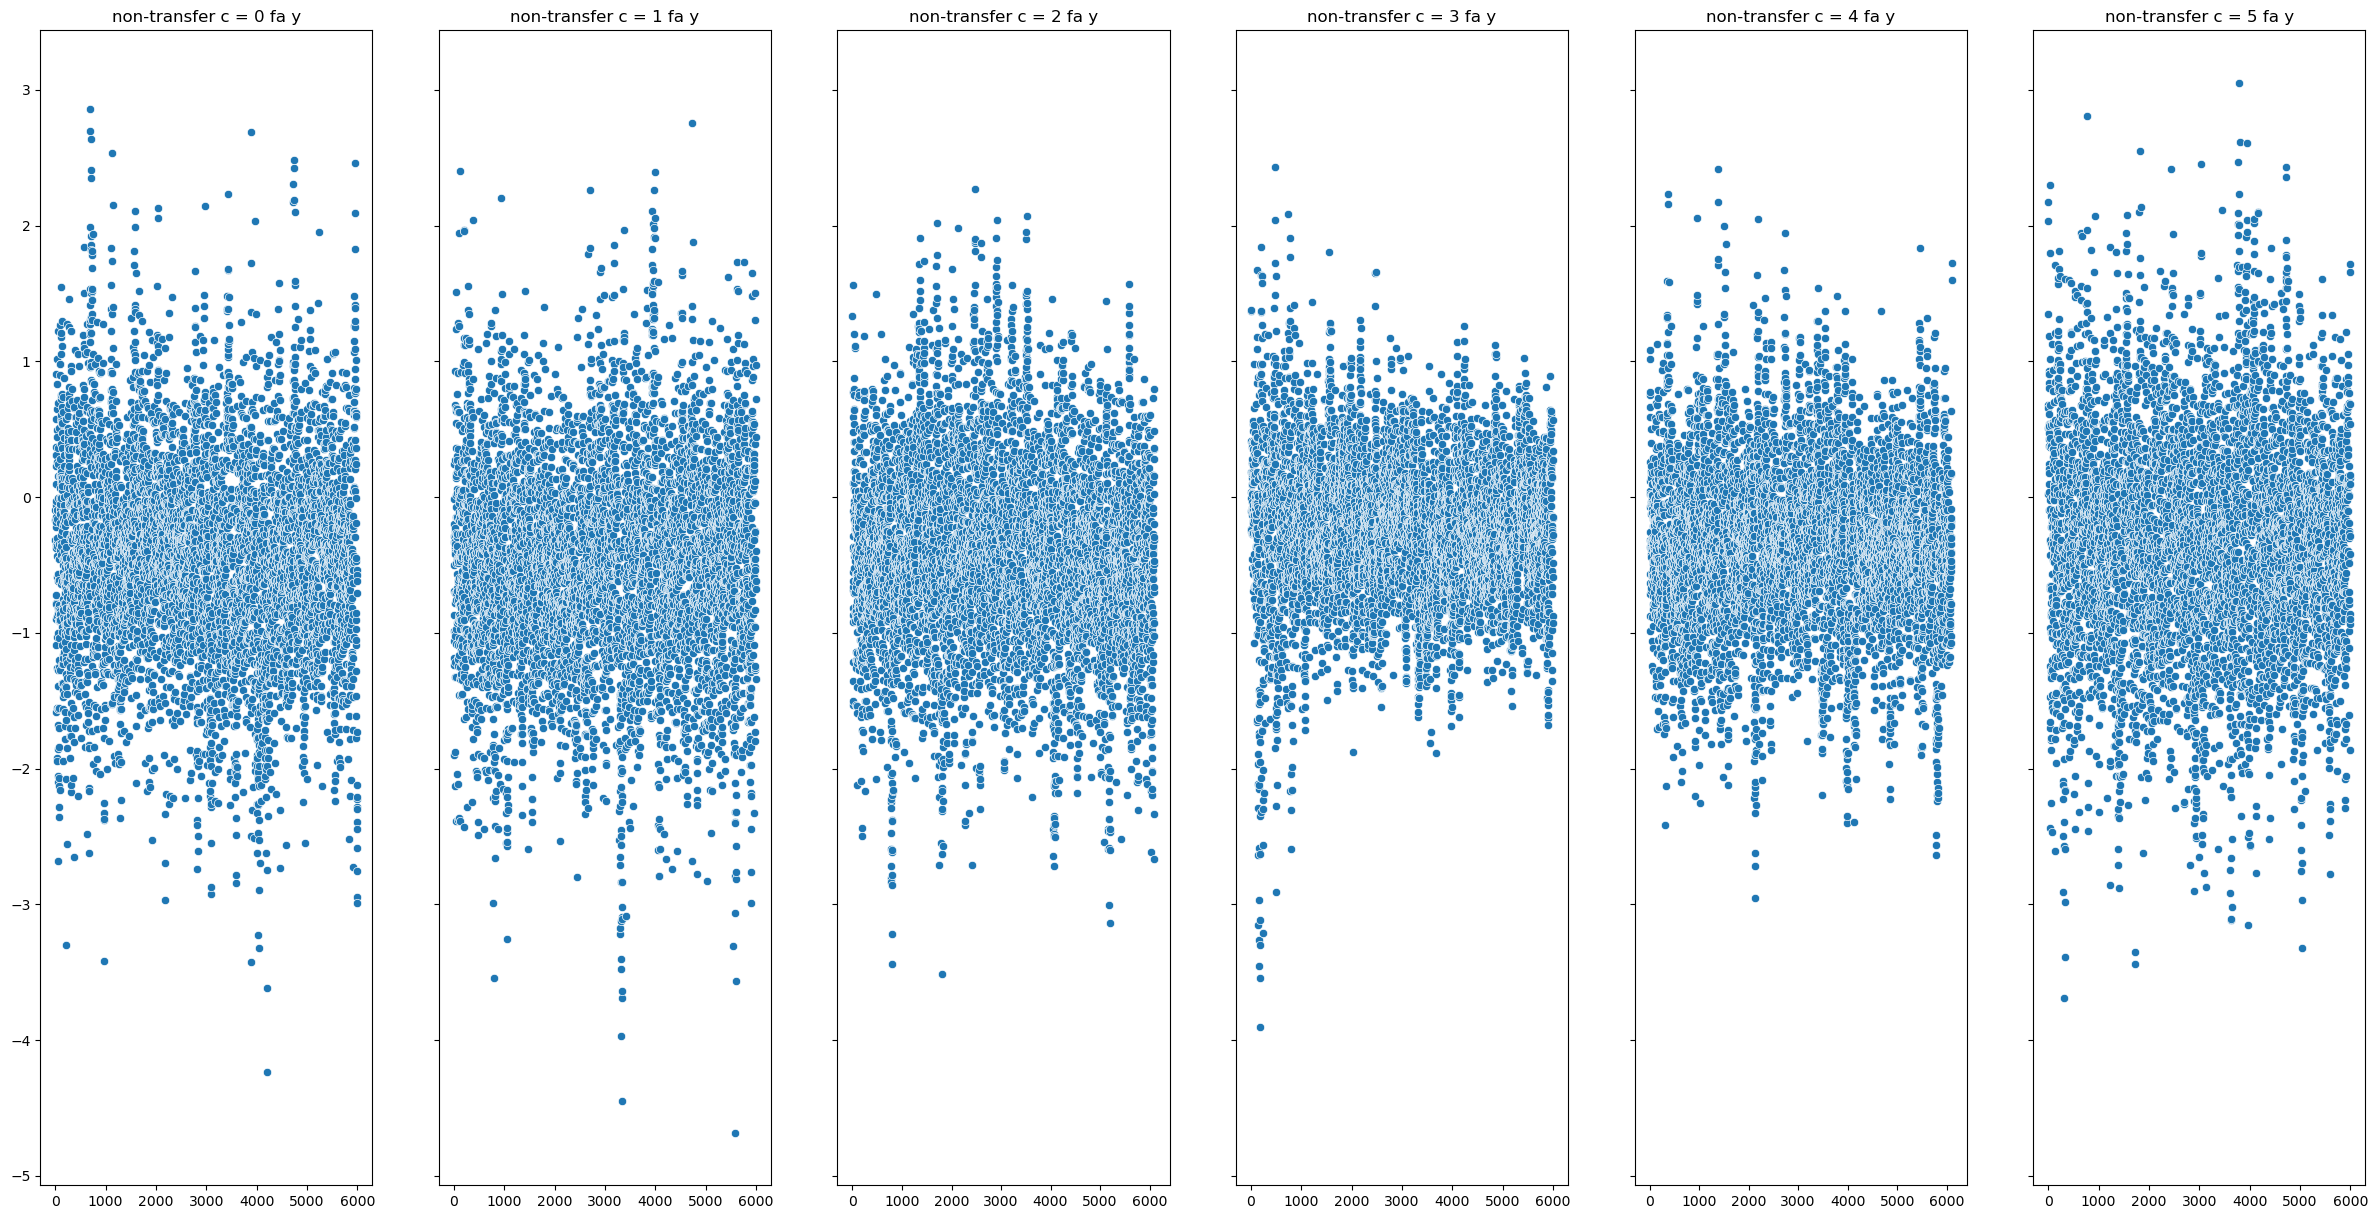

In [45]:
fig, axes = plt.subplots(1,6, figsize=(30,15),sharey=True)
for i in range(6):
  axes[i].set_title(f"non-transfer c = {i} fa y")
  sns.scatterplot(fa_y[i], ax = axes[i])

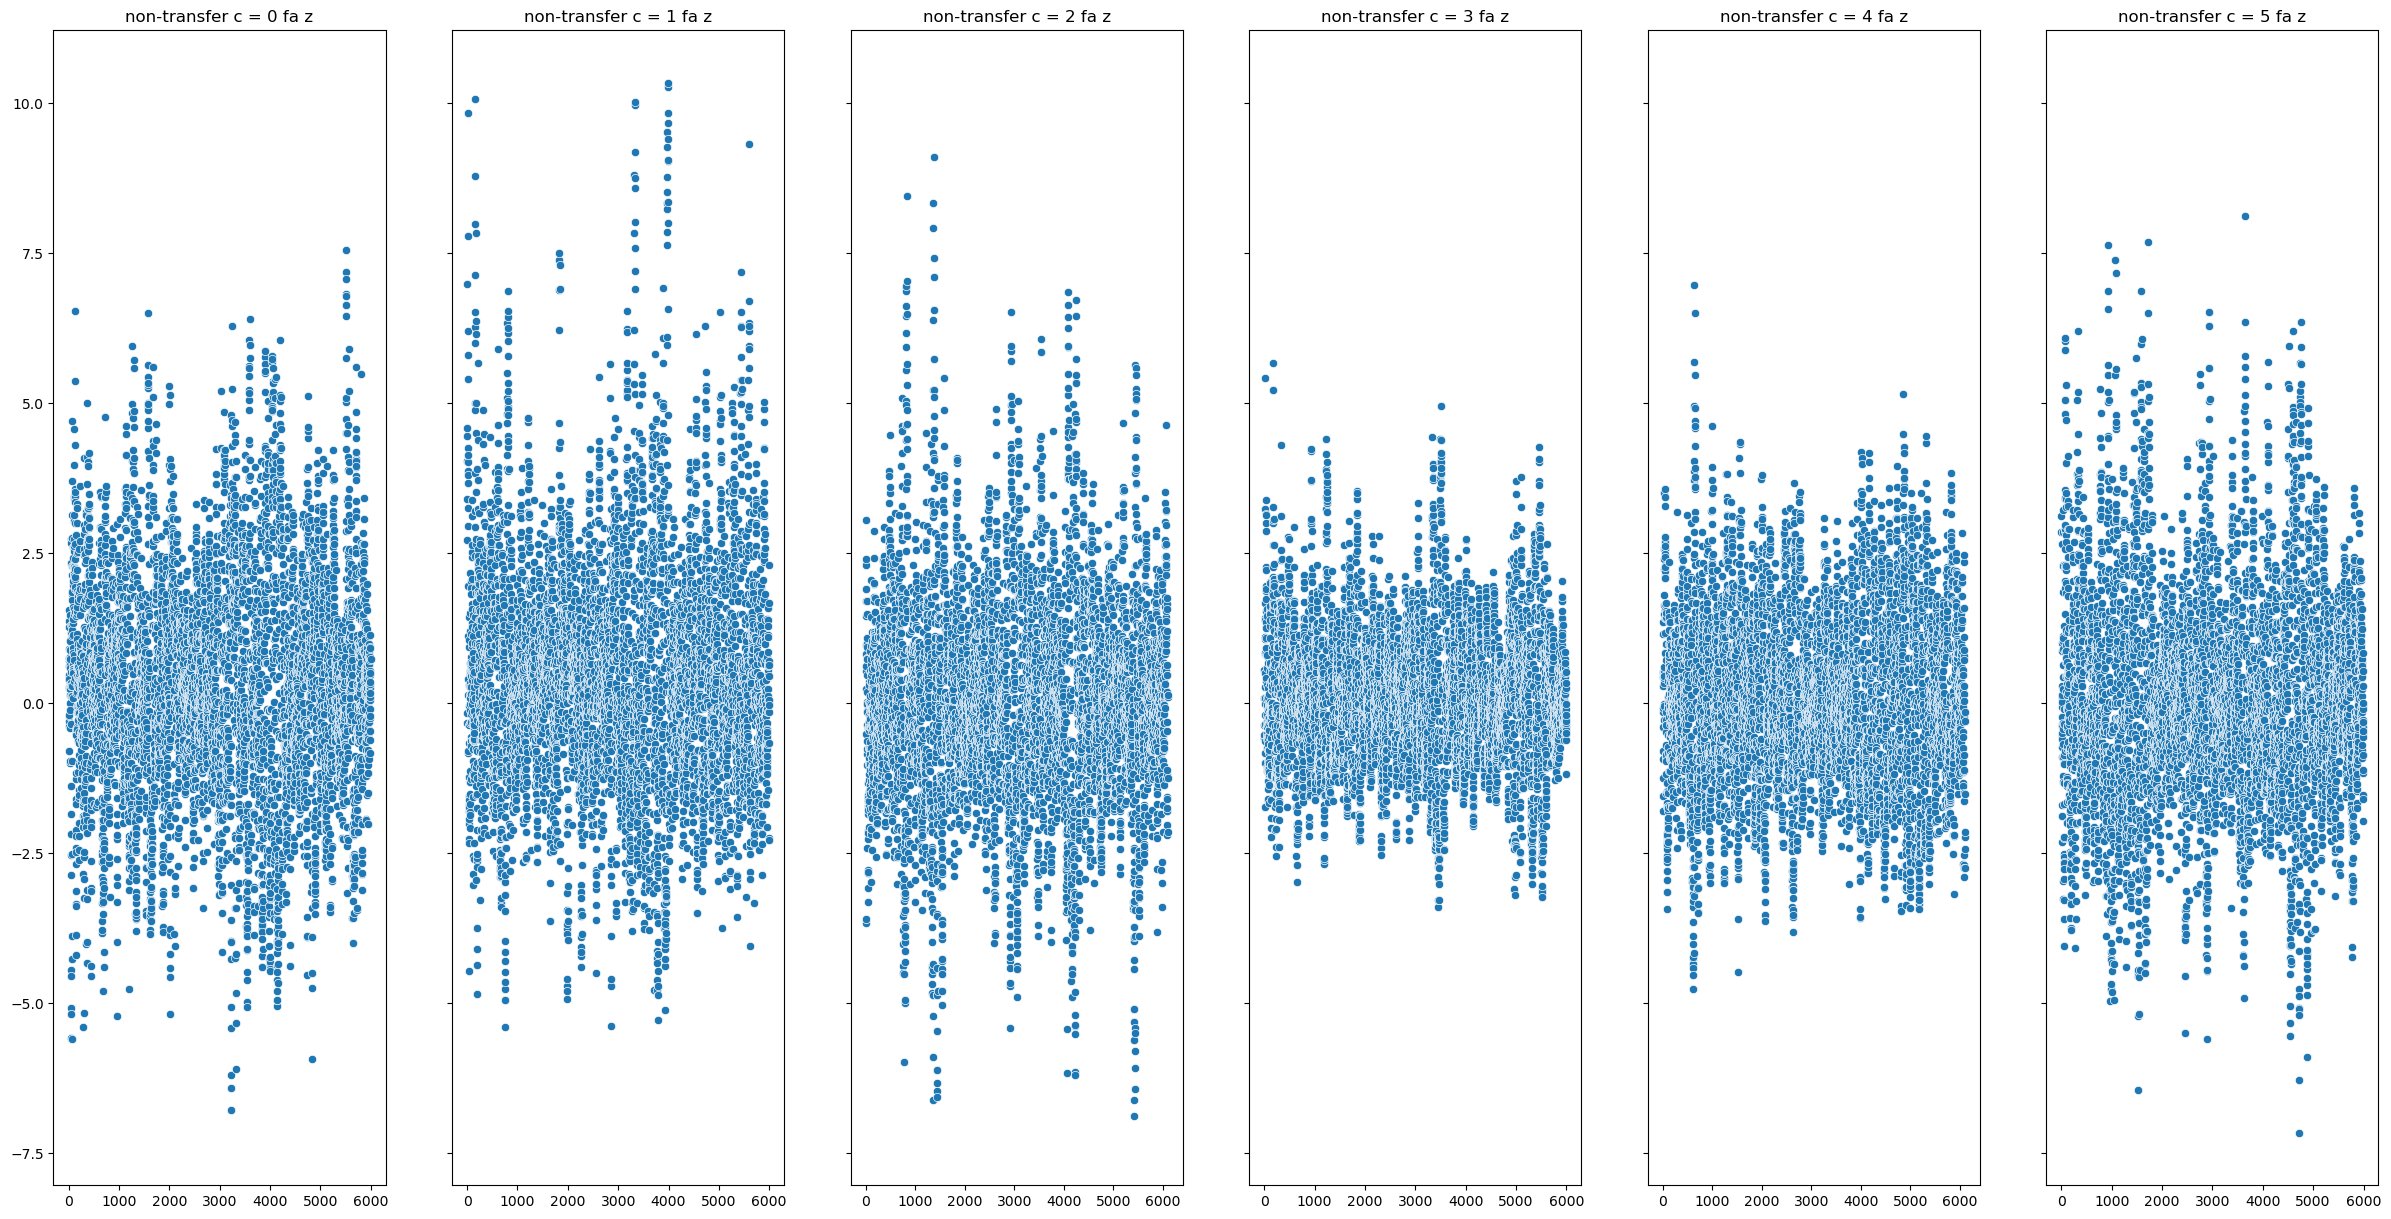

In [47]:
fig, axes = plt.subplots(1,6, figsize=(30,15),sharey=True)
for i in range(6):
  axes[i].set_title(f"non-transfer c = {i} fa z")
  sns.scatterplot(fa_z[i], ax = axes[i])

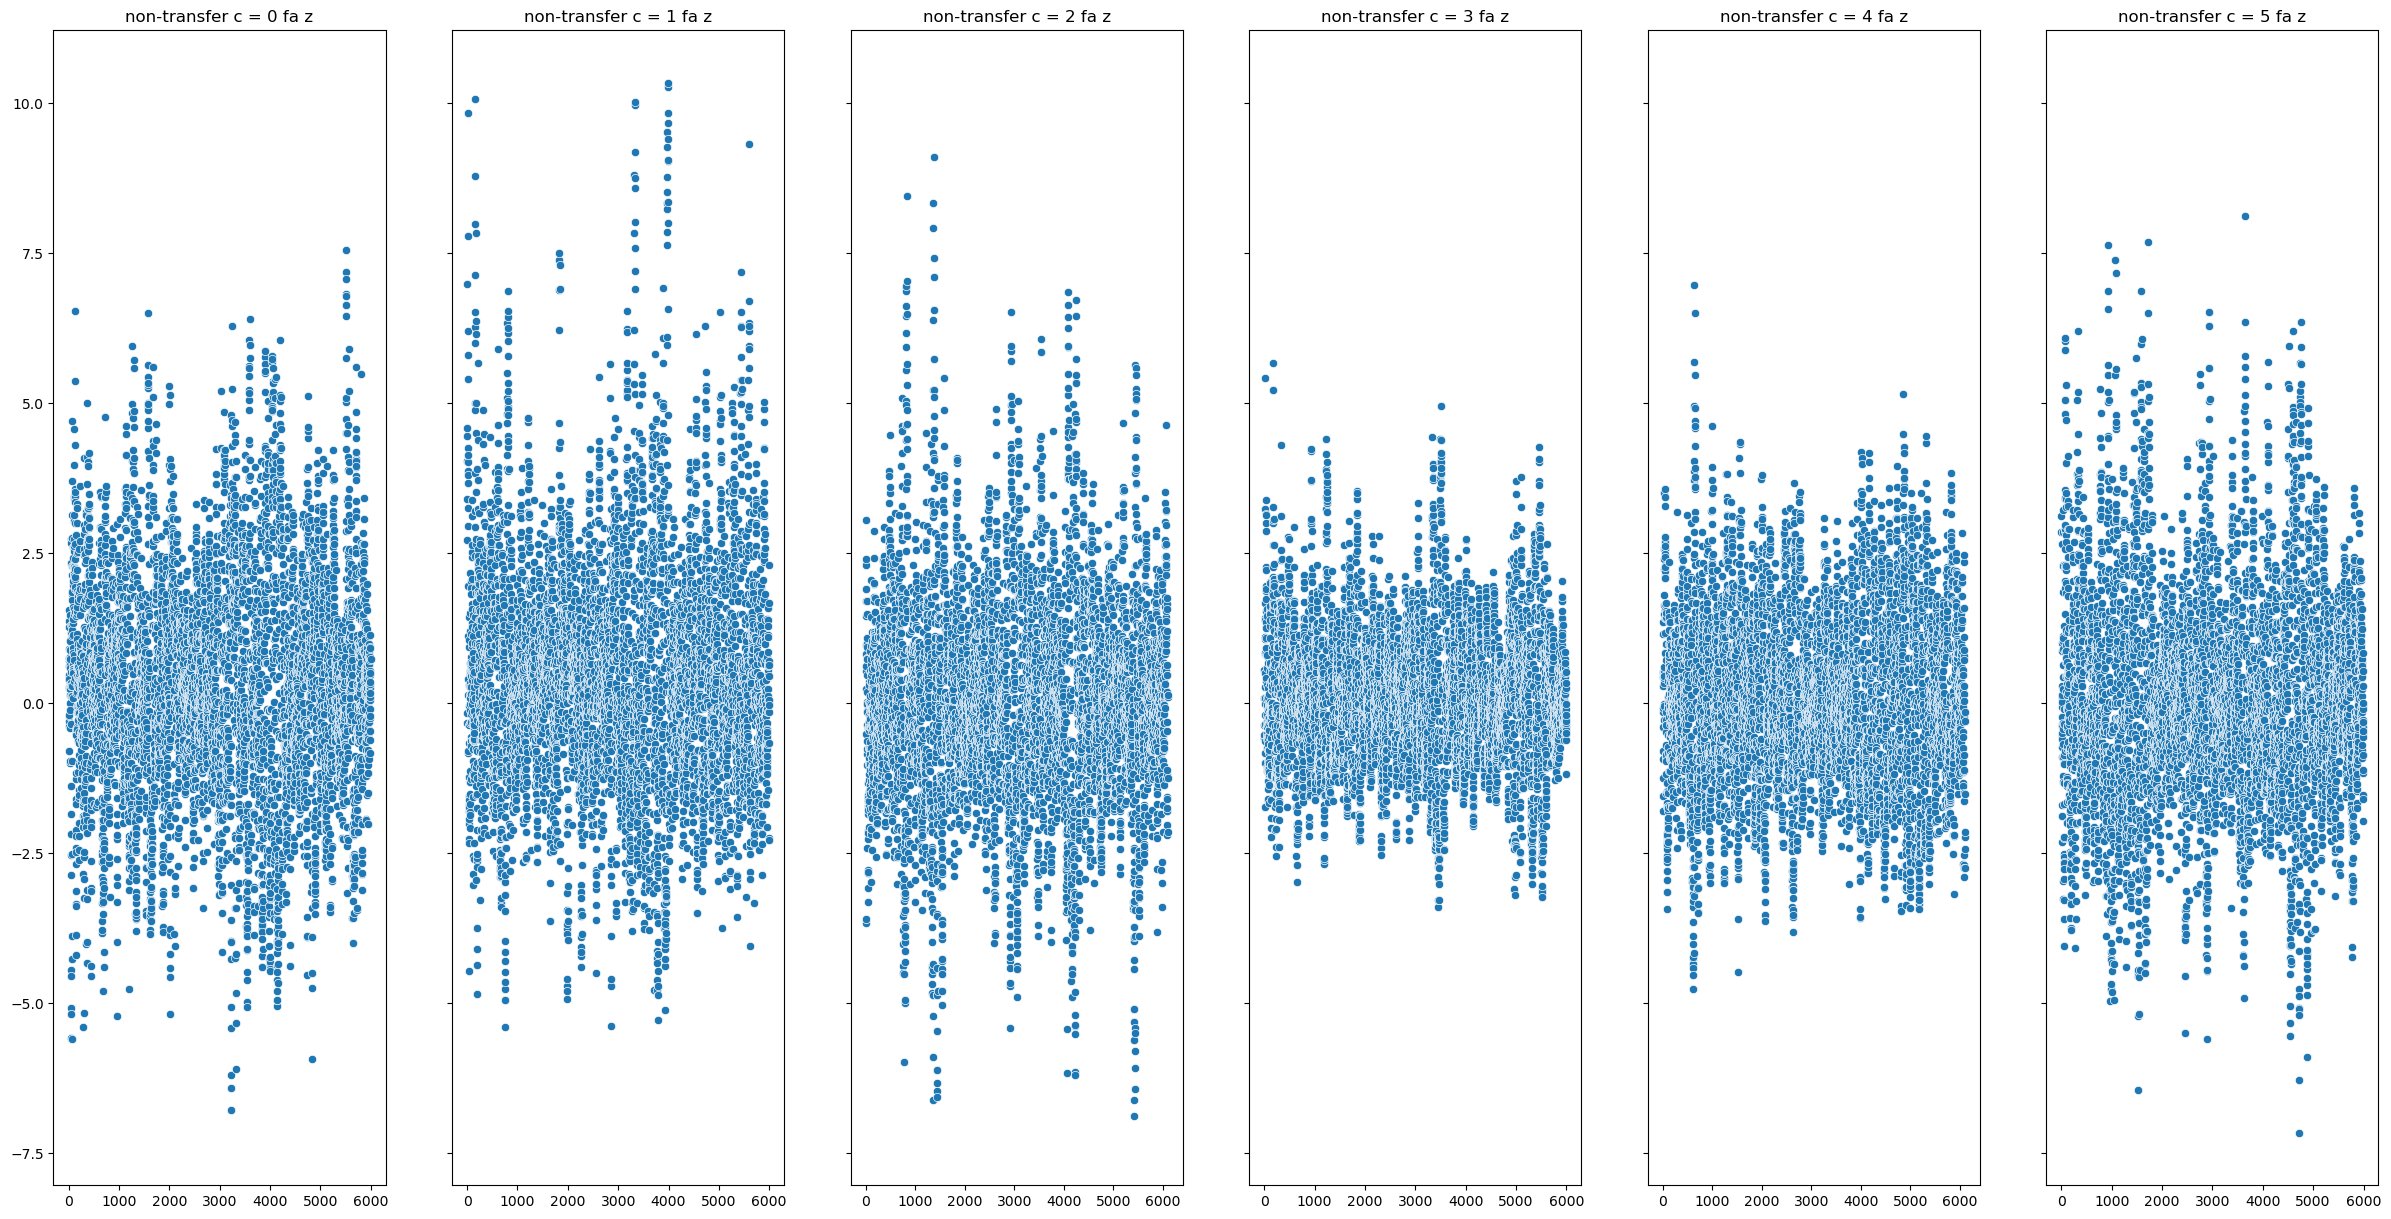

In [48]:
fig, axes = plt.subplots(1,6, figsize=(30,15),sharey=True)
for i in range(6):
  axes[i].set_title(f"non-transfer c = {i} fa z")
  sns.scatterplot(fa_z[i], ax = axes[i])

## Create Training Model

### Uniformly Sampling

Sample the same amount of samples from all source tasks

In [ ]:
trainer_config = {"trainer_name":"pytorch_passive", "max_epoch": 10, "train_batch_size": 1000, "lr": 0.1, "num_workers": 4,\
                  "optim_name": "SGD", "scheduler_name": "StepLR", "step_size": 500, "gamma": 0.1,
                  "test_batch_size": 500}
trainer_config = get_optimizer_fn(trainer_config)
trainer_config = get_scheduler_fn(trainer_config)
model = ModifiedBiLinear(input_dim, task_dim, embed_dim, ret_emb = False)
# model.update_input_embedding(input_embed_matrix)
# model.update_task_embedding(task_embed_matrix)
trainer = PyTorchPassiveTrainer(trainer_config, model)

# Target task only training
total_train_loss = []
total_test_loss = []
for i in range(10):
  trian_loss = trainer.train(dataset, source_task_dict, freeze_rep = False, need_print=True)
  total_train_loss.append(trian_loss)
  test_loss = trainer.test(dataset, test_task_dict)
  total_test_loss.append(test_loss)

In [36]:
outer_epoch_num = 20
base_len_ratio = 1
exp_base = 1.2
condi = 6
culmulative_budgets = []
losses = []
related_source_est_similarities = [0]
task_embed_space_est_similarities_upper = []
task_embed_space_est_similarities_lower = []
avg_training_loss = []


In [37]:
trainer_config = {"trainer_name":"pytorch_passive", "max_epoch": 10, "train_batch_size": 1000, "lr": 0.1, "num_workers": 4,\
                  "optim_name": "SGD", "scheduler_name": "StepLR", "step_size": 500, "gamma": 0.1,
                  "test_batch_size": 500}
trainer_config = get_optimizer_fn(trainer_config)
trainer_config = get_scheduler_fn(trainer_config)
model = ModifiedBiLinear(input_dim, task_dim, embed_dim, ret_emb = False)
trainer = PyTorchPassiveTrainer(trainer_config, model)
strategy_base = RandomSampling(test_task_dict, 1)
strategy_base_fix = FixBaseSampling(test_task_dict,1)

In [ ]:
for outer_epoch in range(outer_epoch_num):
    total_training_loss = 0
    print("Outer epoch: ", outer_epoch)
    if outer_epoch == 0:
        budget = input_dim**2 * embed_dim**2 * condi * base_len_ratio #input_dim&**2 count for hidden layer
        print(f"budget: {budget}")
    else:
        budget = input_dim**2 * embed_dim**2 * condi * base_len_ratio * (exp_base**outer_epoch)
    end_of_epoch = False
    inner_epoch = 0
    while not end_of_epoch:
        cur_task_dict, end_of_epoch = strategy_base_fix.select(source_task_dict, budget, outer_epoch, inner_epoch)
        # dataset.generate_synthetic_data(cur_task_dict, noise_var=1, seed=(154245) if outer_epoch==0 else None) # noise_var=0.2
        dataset.input_ws.update(cur_task_dict)
        # Note here we retrain the model from scratch for each outer epoch. Can we do better? (i.e. start from previous model)
        total_training_loss += trainer.train(dataset, source_task_dict , freeze_rep = False, need_print=False)
        inner_epoch += 1
        
    avg_training_loss.append(total_training_loss/end_of_epoch)
    avg_Loss = trainer.test(dataset, test_task_dict,device = "cpu")
    losses.append(avg_Loss)
    if culmulative_budgets:
        culmulative_budgets.append(culmulative_budgets[-1] + budget)
    else:
        culmulative_budgets.append(budget)

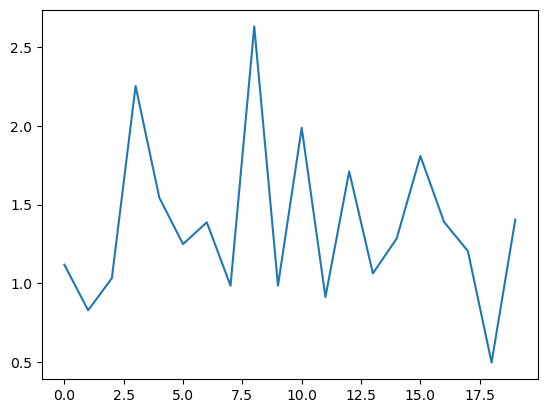

In [39]:
plt.plot(losses)

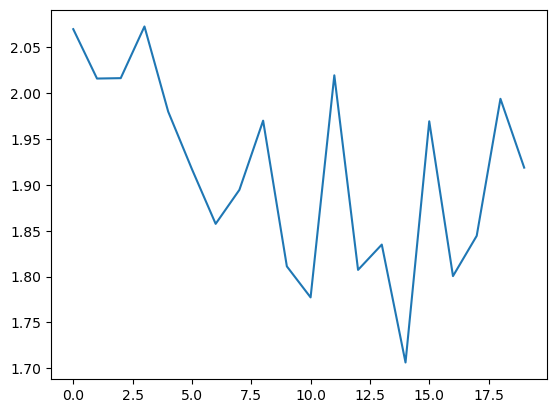

In [40]:
plt.plot(avg_training_loss)

In [ ]:
est_task_restrict_embed_matrix = model.get_restricted_task_embed_matrix()
# est_task_restrict_embed_matrix = np.diag(s) @ vh @ est_task_restrict_embed_matrix
# task_embed_restrict_matrix = synthData_model.get_restricted_task_embed_matrix()
dist_to_upper_bound, dist_to_lower_bound = rowspace_dist2(est_task_restrict_embed_matrix, task_embed_restrict_matrix)
print(f"Task embed dist compared to desired upper bound is {dist_to_upper_bound} and to lower bound is {dist_to_lower_bound}")
print(f"Another task embed dis estimation {rowspace_dist(est_task_restrict_embed_matrix, task_embed_restrict_matrix)}")
task_embed_space_est_similarities_upper.append(dist_to_upper_bound)
task_embed_space_est_similarities_lower.append(dist_to_lower_bound)

In [ ]:
est_task_restrict_embed_matrix = model.get_restricted_task_embed_matrix()
rowspace_dist([est_task_restrict_embed_matrix[:,1]], [est_task_restrict_embed_matrix[:,:-1]])

In [32]:
b_matrix = model.get_full_task_embed_matrix()
target = b_matrix[:,-1] 
def cos_sim(a):
  cos_sim = np.dot(a, target)/(np.linalg.norm(a) * np.linalg.norm(target))
  return cos_sim

In [41]:
task_name_list = np.array(list(source_task_dict.keys()))

In [35]:
cos_sim = np.apply_along_axis(lambda x: cos_sim(x), 0, b_matrix[:,:-1])

In [37]:
sorted_idx_sim = np.argsort(cos_sim)

In [44]:
print("target task: ", task_name_list[-1])
task_name_list[sorted_idx_sim]

target task:  transfer_10_z


array(['transfer_20_z', 'nontransfer_20_z', 'nontransfer_0_y',
       'nontransfer_10_z', 'transfer_40_z', 'transfer_20_y',
       'transfer_0_x', 'nontransfer_20_x', 'transfer_0_y',
       'transfer_40_y', 'nontransfer_40_z', 'nontransfer_0_z',
       'nontransfer_50_z', 'nontransfer_40_y', 'nontransfer_30_z',
       'transfer_30_z', 'nontransfer_50_x', 'transfer_30_y',
       'nontransfer_10_y', 'nontransfer_0_x', 'nontransfer_20_y',
       'transfer_40_x', 'transfer_10_x', 'nontransfer_30_y',
       'nontransfer_30_x', 'nontransfer_40_x', 'transfer_10_y',
       'transfer_0_z', 'transfer_20_x', 'nontransfer_10_x',
       'transfer_30_x', 'nontransfer_50_y'], dtype='<U16')

### Actively sampling

In [ ]:
trainer_config = {"trainer_name":"pytorch_passive", "max_epoch": 10, "train_batch_size": 1000, "lr": 0.1, "num_workers": 4,\
                  "optim_name": "SGD", "scheduler_name": "StepLR", "step_size": 500, "gamma": 0.1,
                  "test_batch_size": 500}
trainer_config = get_optimizer_fn(trainer_config)
trainer_config = get_scheduler_fn(trainer_config)
model = ModifiedBiLinear(input_dim, task_dim, embed_dim, ret_emb = False)
# model.update_input_embedding(input_embed_matrix)
# model.update_task_embedding(task_embed_matrix)
trainer = PyTorchPassiveTrainer(trainer_config, model)

# Target task only training
strategy = MTALSampling()
total_train_loss = []
total_test_loss = []
for i in range(10):
  trian_loss = trainer.train(dataset, source_task_dict, freeze_rep = False, need_print=True)
  #TODO: change the pseudo-code
  new_weight = strategy.select()
  source_task_dict.update(new_weight)
  #
  total_train_loss.append(trian_loss)
  test_loss = trainer.test(dataset, test_task_dict)
  total_test_loss.append(test_loss)

## Visualization

In [16]:
dim = 33
seeds = [5000]
lower_bound_list_base = []
upper_bound_list_base = []
losses_list_base = []

for s in seeds:
  lower_bound_list_base.append(pd.read_csv(f'baseline_results/lower_bound_taskdim{dim}_seed{s}.csv'))
  upper_bound_list_base.append(pd.read_csv(f'baseline_results/upper_bound_taskdim{dim}_seed{s}.csv'))
  losses_list_base.append(pd.read_csv(f'baseline_results/losses_target_agnostic_taskdim{dim}_seed{s}.csv'))
total_lower_base = pd.concat(lower_bound_list_base, axis = 0)
total_upper_base = pd.concat(upper_bound_list_base, axis = 0)
total_losses_base = pd.concat(losses_list_base, axis = 0)

/tmp/ipykernel_2876486/2660532857.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="training_loss", data=total_losses_base, ax = axes[0], ci='sd')
/tmp/ipykernel_2876486/2660532857.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses_base, ax = axes[1], ci='sd')


<Axes: title={'center': 'test loss'}, xlabel='budget', ylabel='loss'>

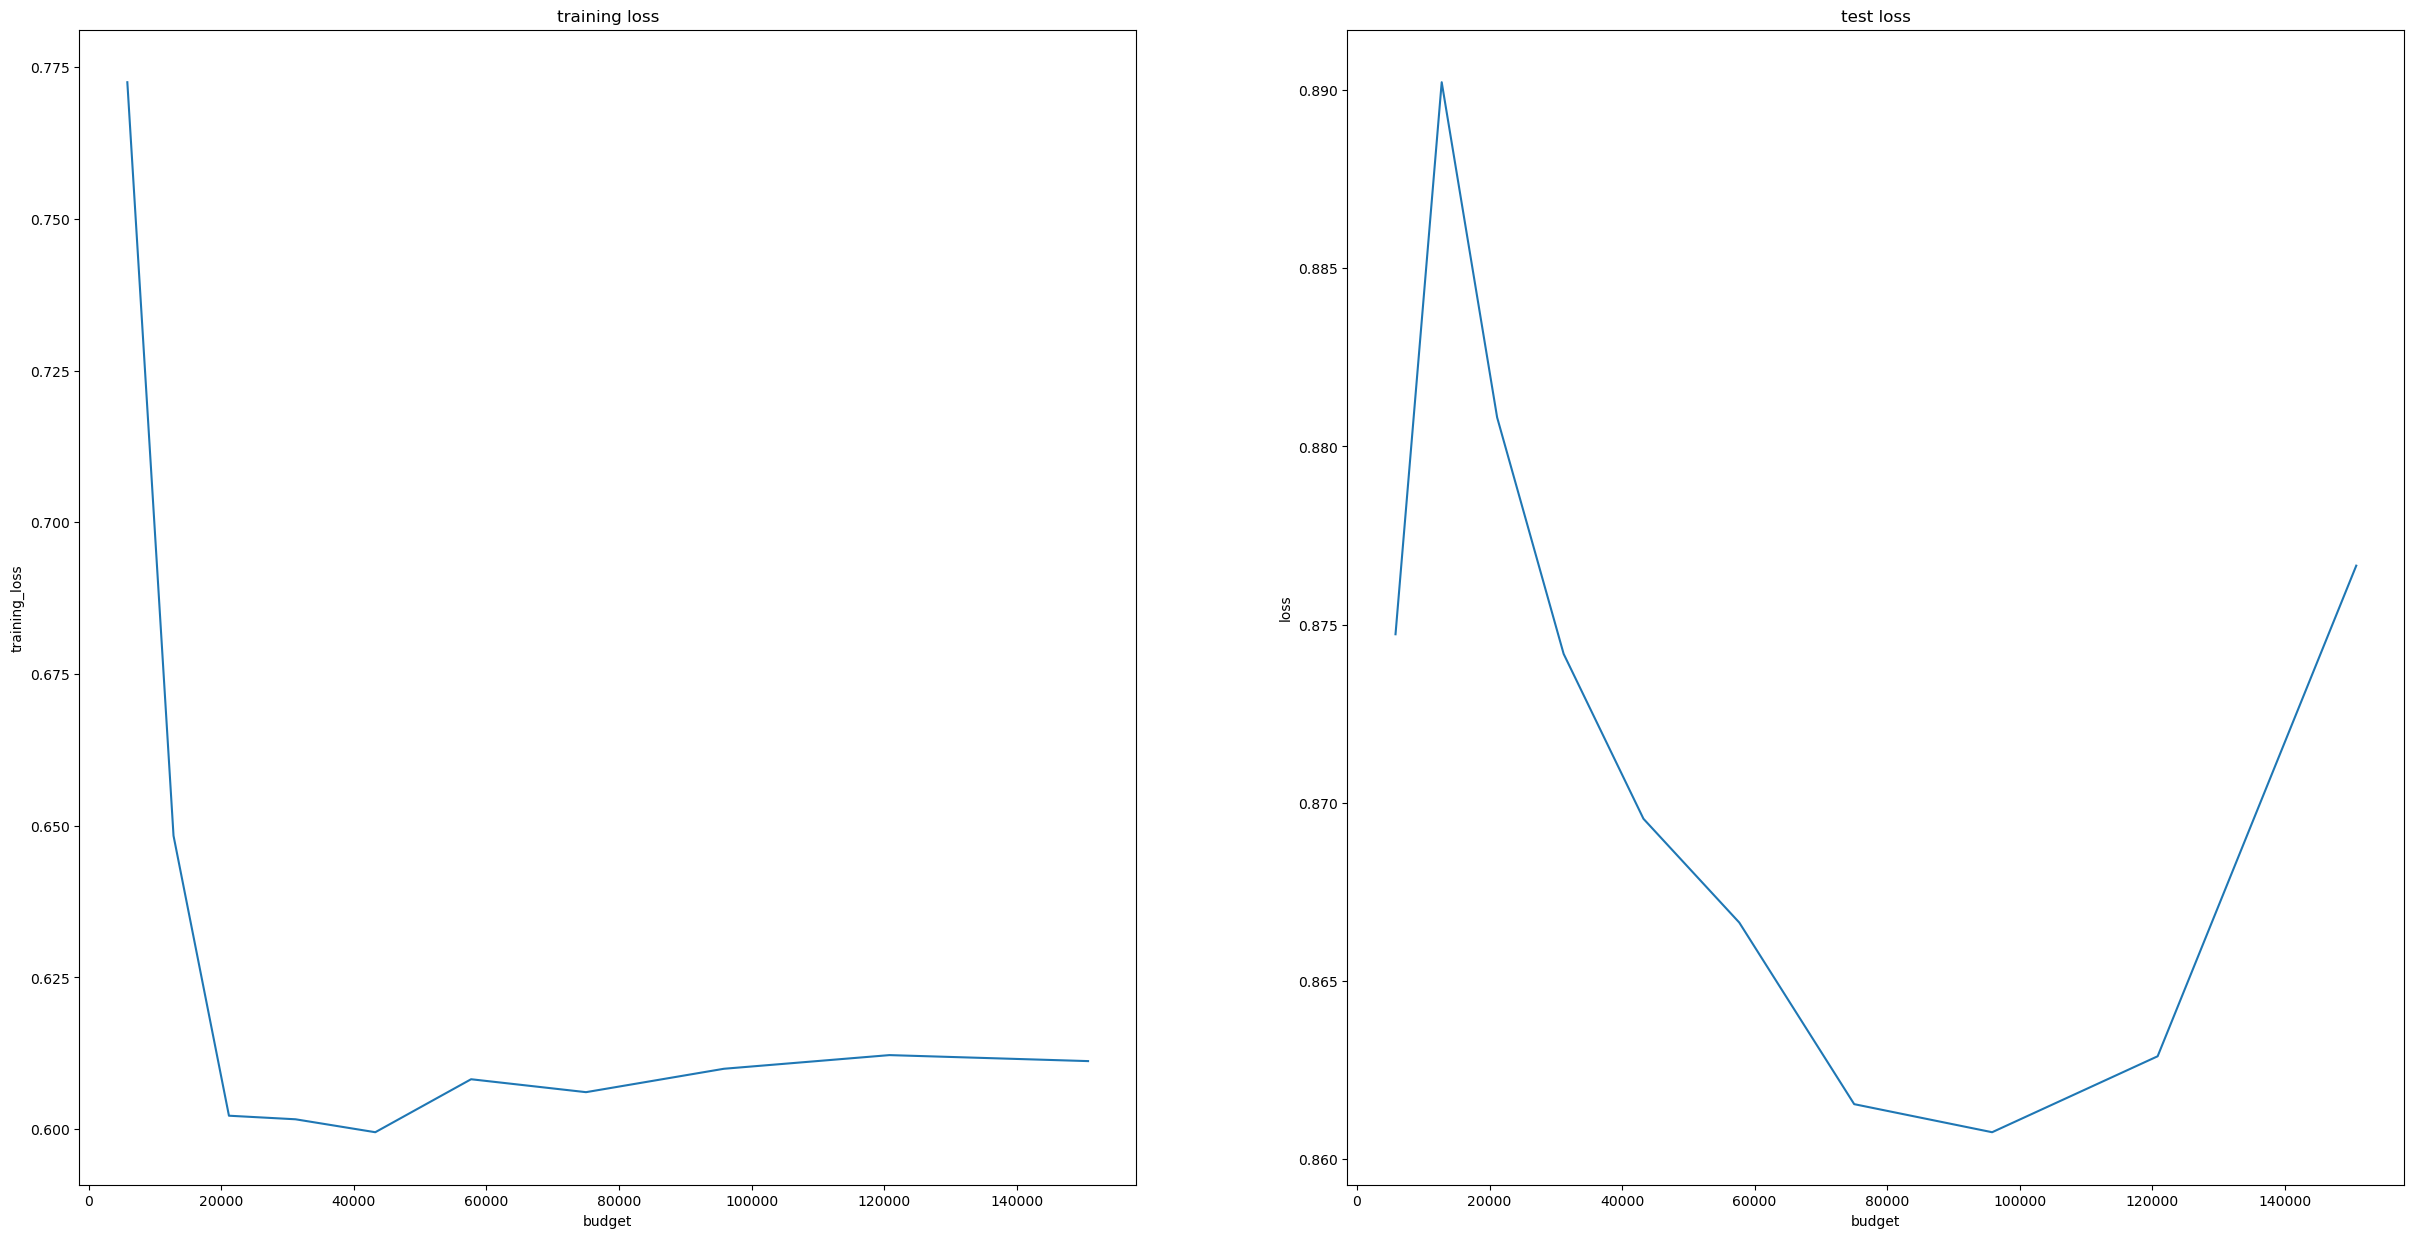

In [17]:
fig, axes = plt.subplots(1,2, figsize=(30,15))
axes[0].set_title("training loss")
sns.lineplot(x="budget", y="training_loss", data=total_losses_base, ax = axes[0], ci='sd')

axes[1].set_title("test loss")
sns.lineplot(x="budget", y="loss", data=total_losses_base, ax = axes[1], ci='sd')



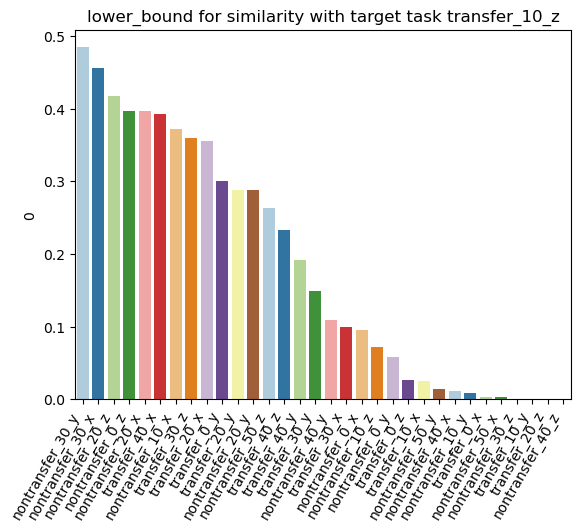

In [16]:
task_name_list = np.array(list(source_task_dict.keys()))
idx = np.argsort(lower_bound["0"])[::-1]
ax = sns.barplot(x = task_name_list[idx], y = lower_bound["0"][idx], palette="Paired")

ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title(f"lower_bound for similarity with target task {task_name_list[-1]}")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

### Active Sampling

In [21]:
dim=33
seeds = [5000]
lower_bound_list = []
upper_bound_list = []
losses_list = []

for s in seeds:
  lower_bound_list.append(pd.read_csv(f'active_results/lower_bound_taskdim{dim}_seed{s}.csv'))
  upper_bound_list.append(pd.read_csv(f'active_results/upper_bound_taskdim{dim}_seed{s}.csv'))
  losses_list.append(pd.read_csv(f'active_results/losses_target_agnostic_taskdim{dim}_seed{s}.csv'))
total_lower = pd.concat(lower_bound_list, axis = 0)
total_upper = pd.concat(upper_bound_list, axis = 0)
total_losses = pd.concat(losses_list, axis = 0)

/tmp/ipykernel_2876486/4214056647.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="training_loss", data=total_losses, ax = axes[0], ci="sd")
/tmp/ipykernel_2876486/4214056647.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses, ax = axes[1], ci="sd")


<Axes: title={'center': 'test loss'}, xlabel='budget', ylabel='loss'>

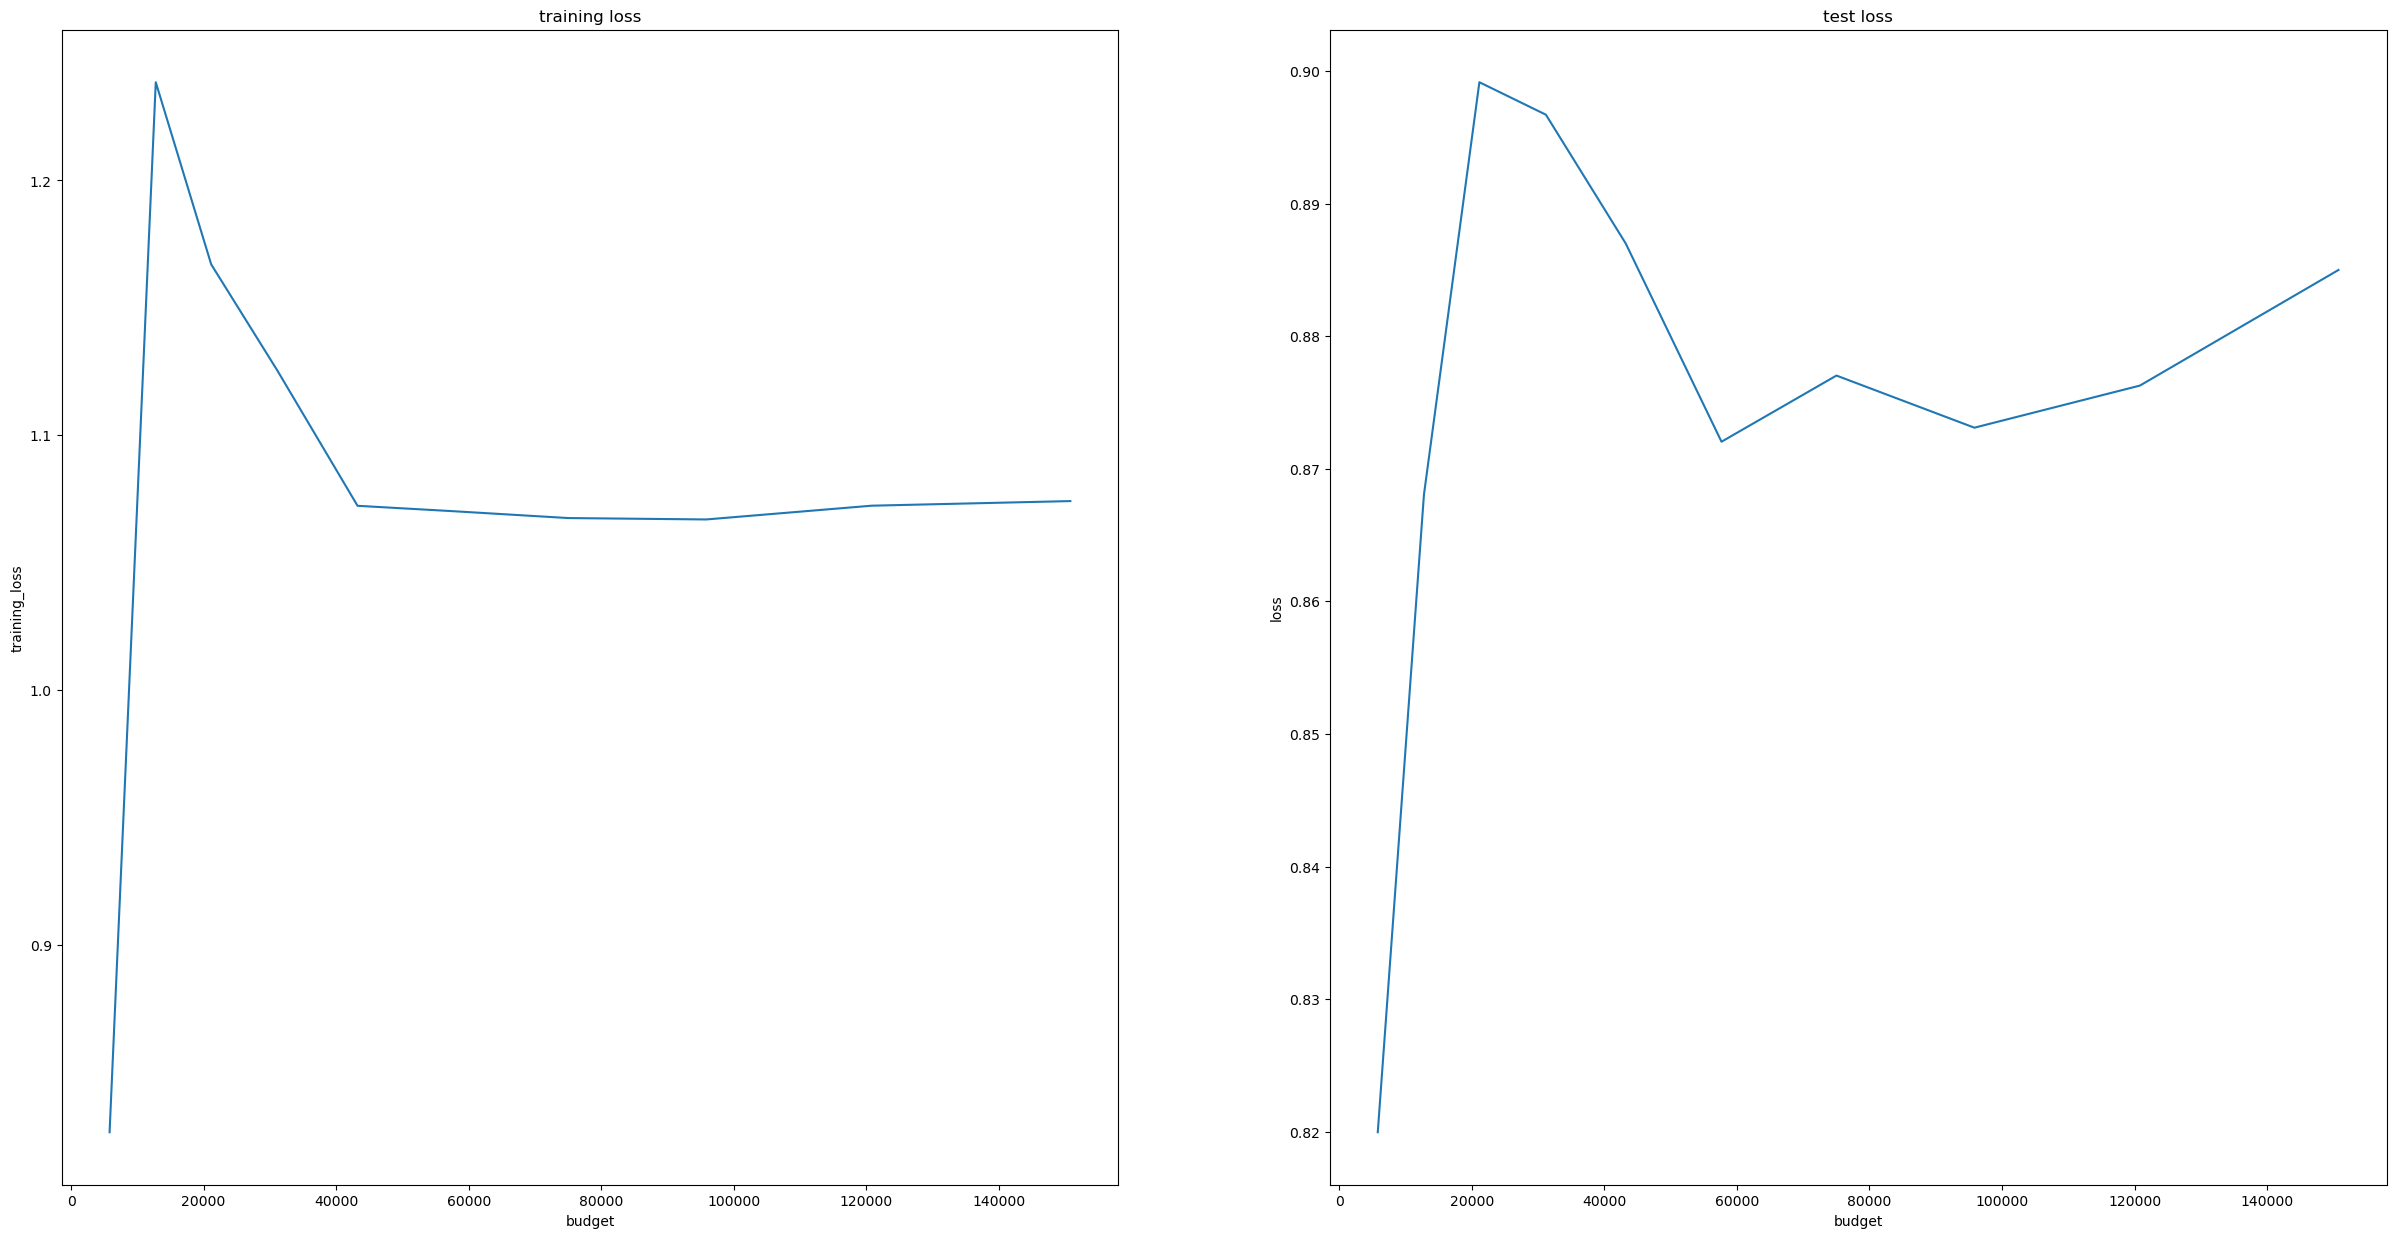

In [22]:
fig, axes = plt.subplots(1,2, figsize=(30,15))
axes[0].set_title("training loss")
sns.lineplot(x="budget", y="training_loss", data=total_losses, ax = axes[0], ci="sd")

axes[1].set_title("test loss")
sns.lineplot(x="budget", y="loss", data=total_losses, ax = axes[1], ci="sd")

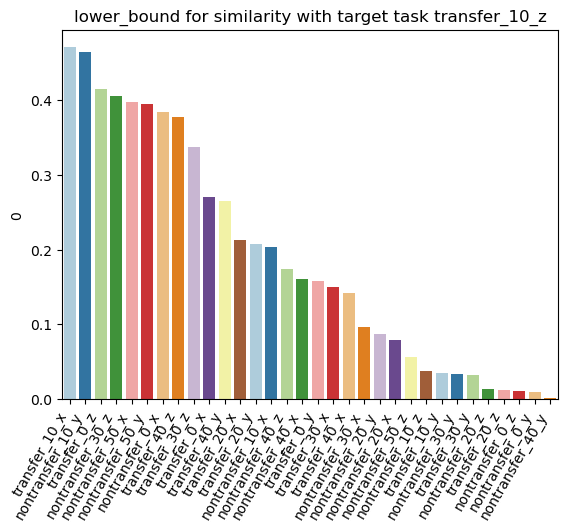

In [49]:
task_name_list = np.array(list(source_task_dict.keys()))
idx = np.argsort(active_lower_bound["0"])[::-1]
ax = sns.barplot(x = task_name_list[idx], y = active_lower_bound["0"][idx], palette="Paired")

ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title(f"lower_bound for similarity with target task {task_name_list[-1]}")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

/tmp/ipykernel_2559555/1022941568.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses_base, axes = ax, ci="sd", legend=True)
/tmp/ipykernel_2559555/1022941568.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses, axes = ax, ci="sd",legend=True)


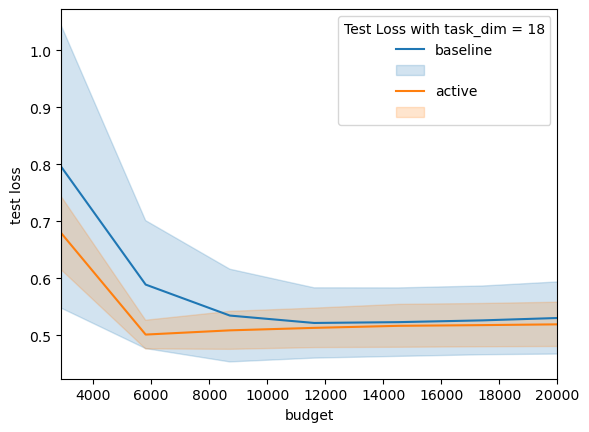

In [39]:
# axes[0].set_title("training loss baseline")
fig, ax = plt.subplots()
sns.lineplot(x="budget", y="loss", data=total_losses_base, axes = ax, ci="sd", legend=True)
# axes[1].set_title("training loss active ")
sns.lineplot(x="budget", y="loss", data=total_losses, axes = ax, ci="sd",legend=True)
ax.set_xlim(2904, 20000)
ax.set_ylabel("test loss")
plt.legend(title='Test Loss with task_dim = 18', loc='upper right', labels=['baseline', '', "active", ""])
plt.show()

In [12]:
seeds = [1000]
lower_bound_list = []
upper_bound_list = []
losses_list = []
dim = 18
for s in seeds:
  lower_bound_list.append(pd.read_csv(f'active_results/lower_bound_taskdim{dim}_seed{s}.csv'))
  upper_bound_list.append(pd.read_csv(f'active_results/upper_bound_taskdim{dim}_seed{s}.csv'))
  losses_list.append(pd.read_csv(f'active_results/losses_target_agnostic_taskdim{dim}_seed{s}.csv'))
total_lower = pd.concat(lower_bound_list, axis = 1)
total_upper = pd.concat(upper_bound_list, axis = 1)
total_losses = pd.concat(losses_list, axis = 0)

/tmp/ipykernel_928640/4214056647.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="training_loss", data=total_losses, ax = axes[0], ci="sd")
/tmp/ipykernel_928640/4214056647.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses, ax = axes[1], ci="sd")


<Axes: title={'center': 'test loss'}, xlabel='budget', ylabel='loss'>

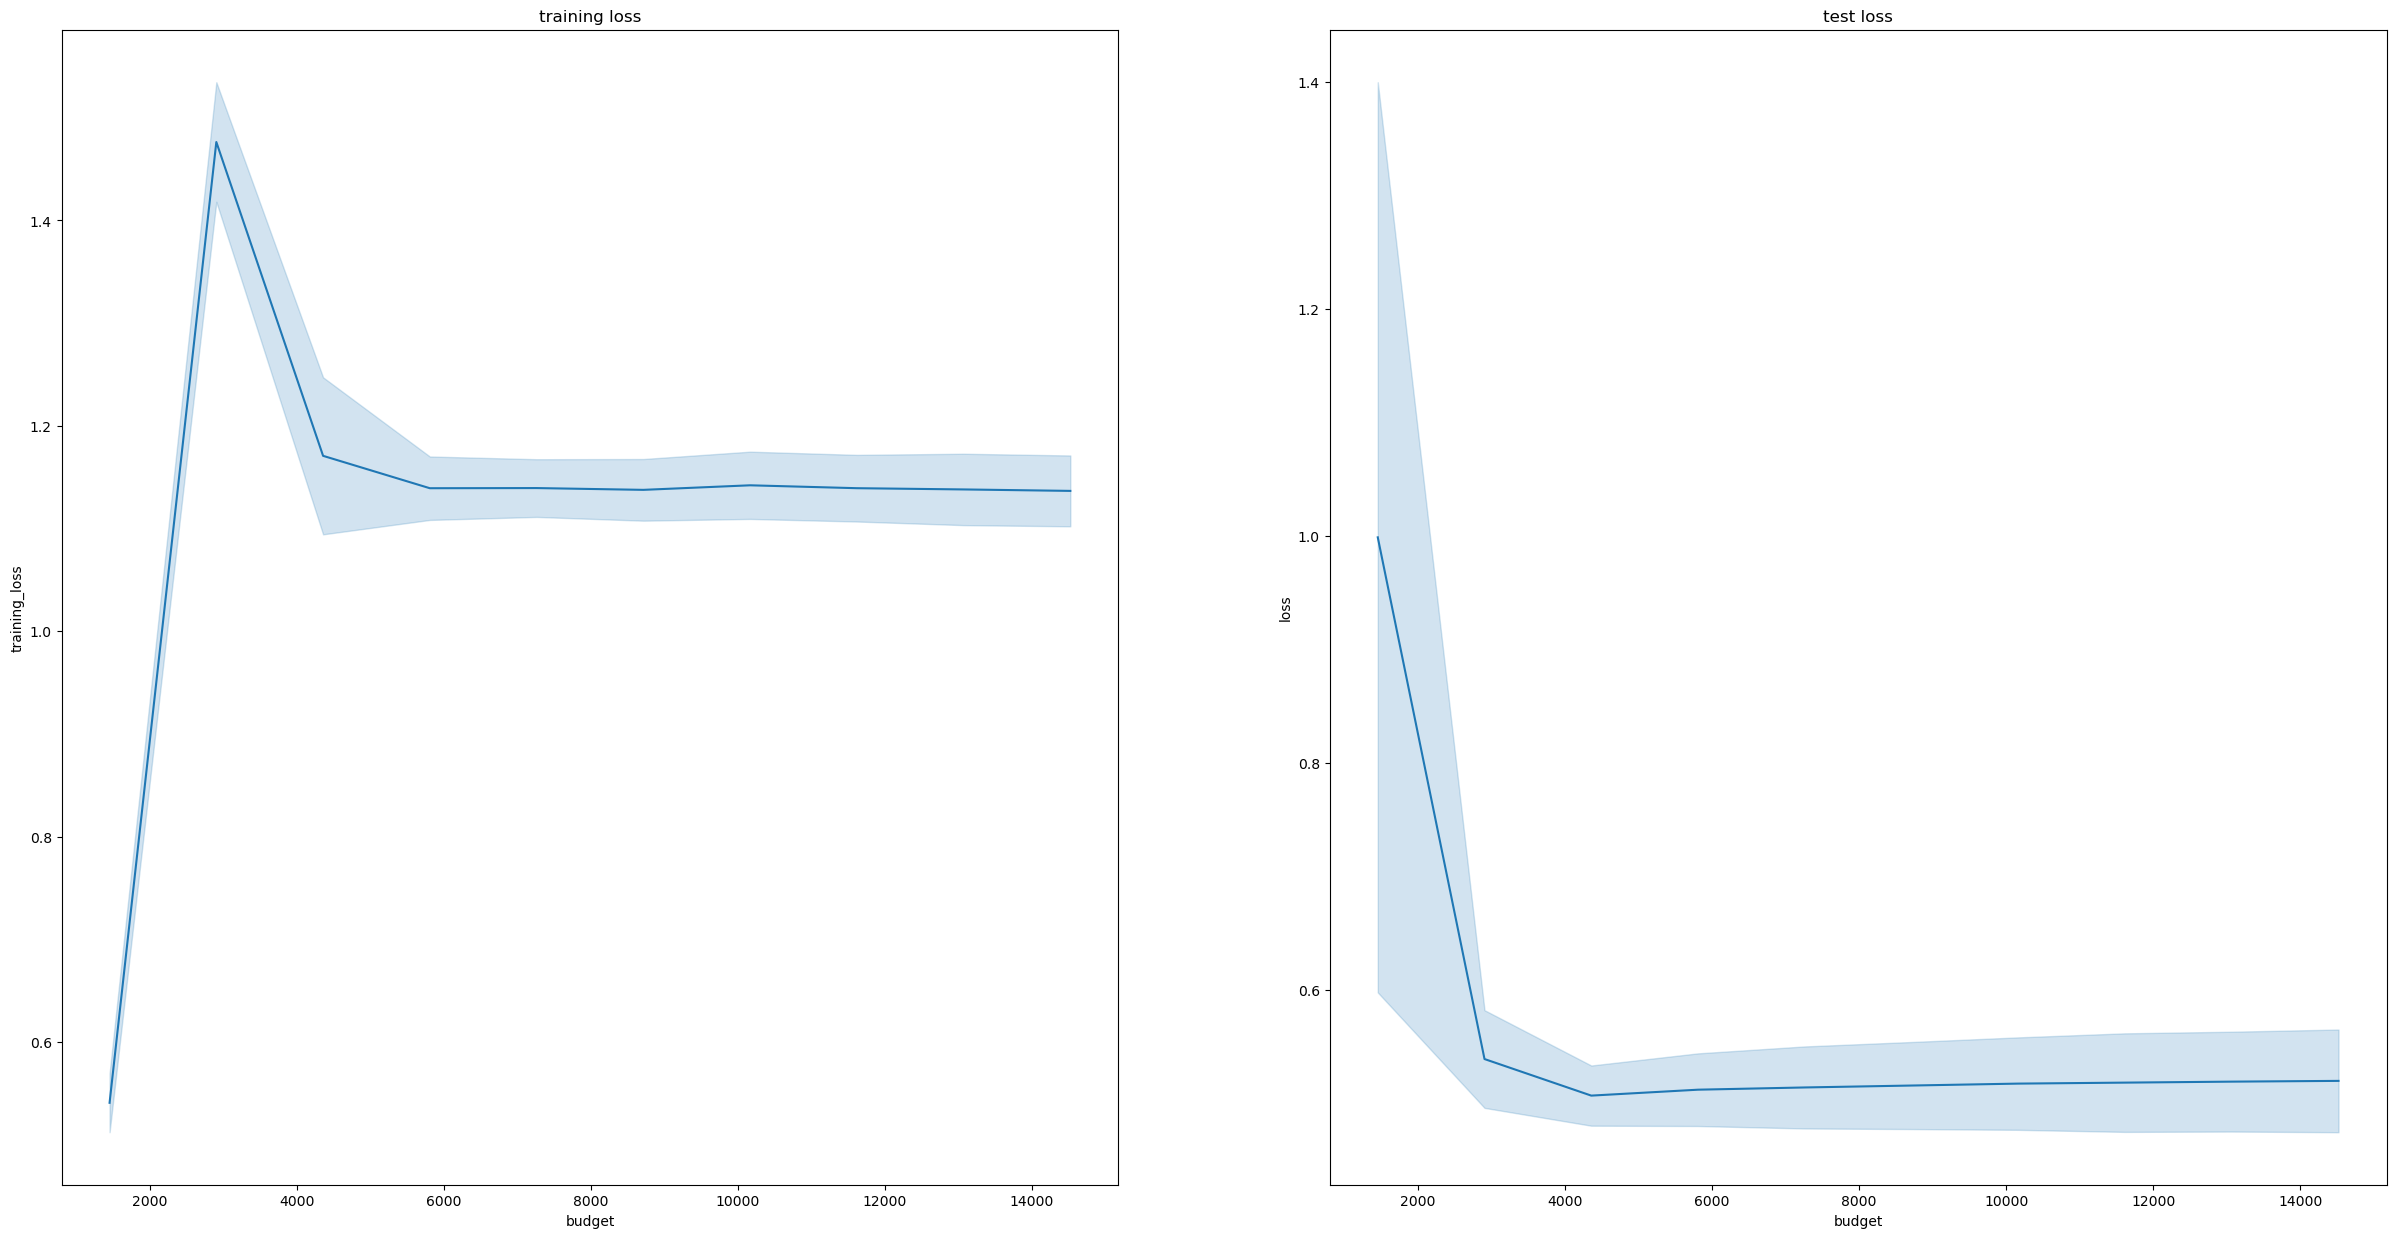

In [4]:
fig, axes = plt.subplots(1,2, figsize=(30,15))
axes[0].set_title("training loss")
sns.lineplot(x="budget", y="training_loss", data=total_losses, ax = axes[0], ci="sd")

axes[1].set_title("test loss")
sns.lineplot(x="budget", y="loss", data=total_losses, ax = axes[1], ci="sd")

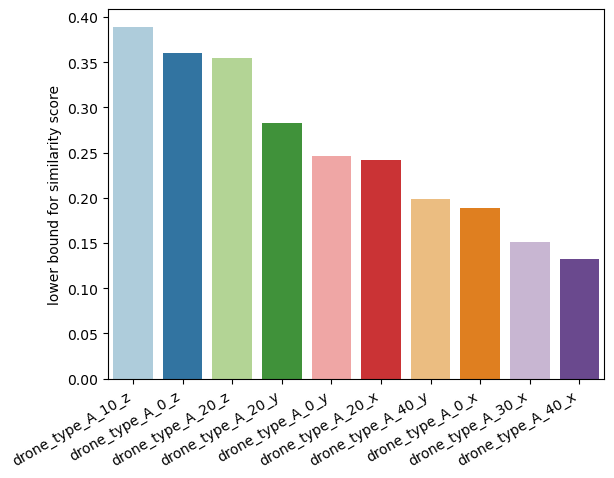

In [13]:
task_name_list = np.array(list(source_task_dict.keys()))[:18]
# total_lower=(total_lower-total_lower.mean())/total_lower.std()
total_lower["avg"] = total_lower.mean(numeric_only=True, axis=1)
# idx = np.argsort(total_lower["avg"])[::-1]
idx = np.argsort(total_lower["avg"])[::-1][:10]
# ax = sns.barplot(x = task_name_list[idx], y = total_lower["avg"][idx], palette="Paired")
ax = sns.barplot(x = task_name_list[idx], y = total_lower["avg"][idx], palette="Paired")
ax.set_ylabel("lower bound for similarity score")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# plt.title(f"lower_bound for similarity with target task {task_name_list[-1]}")
plt.rcParams["figure.figsize"] = (7.5,5)
plt.show()

/tmp/ipykernel_3525469/493708916.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="training_loss", data=total_losses_base, ax = axes[0], ci="sd")
/tmp/ipykernel_3525469/493708916.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses_base, ax = axes[1], ci="sd")


<Axes: title={'center': 'test loss'}, xlabel='budget', ylabel='loss'>

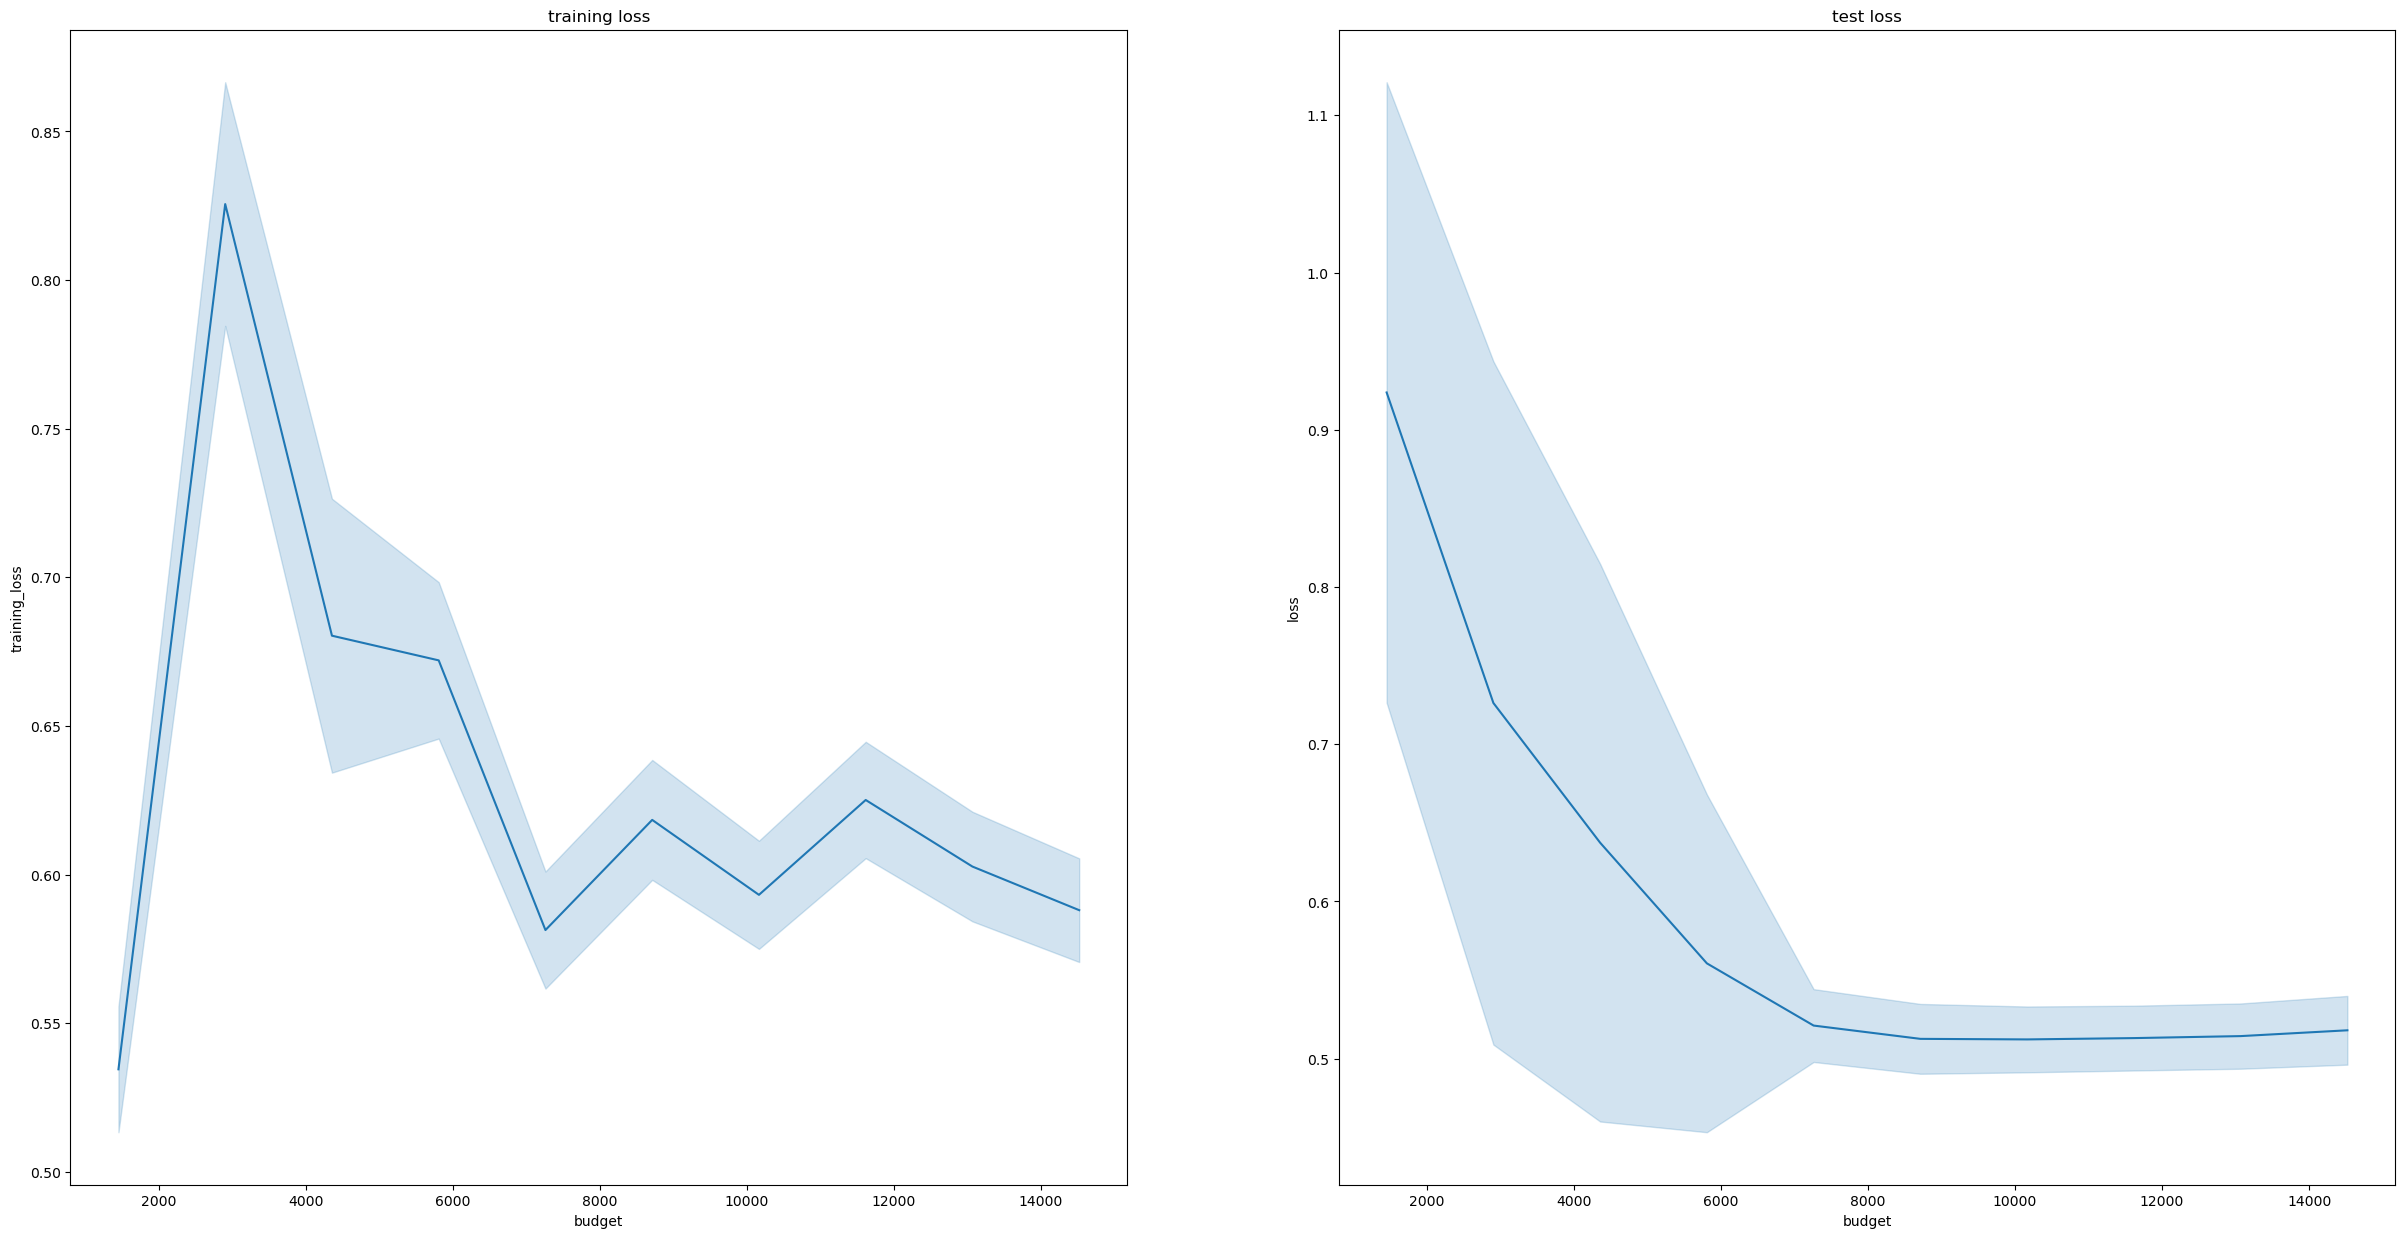

In [48]:
seeds = [1, 100, 500, 1000, 5000]
lower_bound_list_base = []
upper_bound_list_base = []
losses_list_base = []
dim = 18
for s in seeds:
  lower_bound_list_base.append(pd.read_csv(f'baseline_results/lower_bound_taskdim{dim}_seed{s}.csv'))
  upper_bound_list_base.append(pd.read_csv(f'baseline_results/upper_bound_taskdim{dim}_seed{s}.csv'))
  losses_list_base.append(pd.read_csv(f'baseline_results/losses_target_agnostic_taskdim{dim}_seed{s}.csv'))
total_lower_base = pd.concat(lower_bound_list_base, axis = 0)
total_upper_base = pd.concat(upper_bound_list_base, axis = 0)
total_losses_base = pd.concat(losses_list_base, axis = 0)

fig, axes = plt.subplots(1,2, figsize=(30,15))
axes[0].set_title("training loss")
sns.lineplot(x="budget", y="training_loss", data=total_losses_base, ax = axes[0], ci="sd")

axes[1].set_title("test loss")
sns.lineplot(x="budget", y="loss", data=total_losses_base, ax = axes[1], ci="sd")

/tmp/ipykernel_3525469/487550472.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses, axes = ax, ci="sd",label="AL_target_aware")
/tmp/ipykernel_3525469/487550472.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="budget", y="loss", data=total_losses_base, axes = ax, ci="sd", label = "passive")


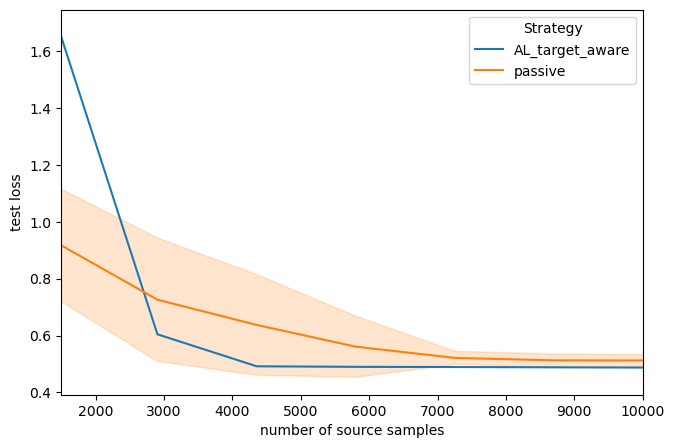

In [49]:
# axes[0].set_title("training loss baseline")
fig, ax = plt.subplots()
sns.lineplot(x="budget", y="loss", data=total_losses, axes = ax, ci="sd", label="AL_target_aware")
sns.lineplot(x="budget", y="loss", data=total_losses_base, axes = ax, ci="sd", label = "passive")
# axes[1].set_title("training loss active ")
ax.set_xlim(1500, 10000)
ax.set_ylabel("test loss")
ax.set_xlabel("number of source samples")
plt.legend(title='Strategy')
plt.show(ax)